# ⚡ Time-Series Clustering of Electricity Consumers Using Smart Meter Data (London)

## 📌 Project Objective

This project applies unsupervised machine learning techniques to cluster electricity consumers based on their energy consumption patterns, using high-resolution smart meter data from London households. 

The key goal is to uncover behavioral usage profiles that can support:

- 🔌 **Demand-side energy management**
- 💡 **Tariff design and segmentation**
- 🏠 **Customer behavior understanding**
- 🌍 **Energy efficiency and sustainability strategies**

## 📊 Data Source

- 📁 **Dataset**: UK Power Networks — London Smart Meter Data
- 🕒 **Time Period**: Nov 2011 to Feb 2014
- 🔢 **Resolution**: Half-hourly electricity usage
- 👥 **Consumers**: ~5,000 residential meters
- 🌍 **Location**: Greater London Area

The dataset is publicly available via the **London Data Store** and was used in prior studies including:
- Chakraborty, N. (2023), *Time-Series Clustering for Smart Meter Dataset*
- Okereke et al. (2023), *K-means Clustering of Electricity Consumers Using Time-Domain Features*

## 🧠 What This Notebook Covers

- Time-based feature extraction (daily, seasonal, part-of-day patterns)
- Multiple clustering techniques:
  - **KMeans**
  - **Autoencoder + KMeans**
  - **DBSCAN**
- Visual exploration of clustered behavior
- Demographic and seasonal consumption trends
- Correlation with external variables like weather

## 📌 Expected Outcomes

- Identification of behavior-based customer segments
- Insightful visualizations of seasonal, temporal, and demographic usage patterns
- Evaluation of clustering quality using metrics (e.g., Silhouette Score, DBI)

## 📦 Imports & Setup

This section loads the necessary Python packages used throughout the project. Libraries are grouped by purpose:

- 📦 **Data Processing**: For loading, reshaping, and transforming time-series data (`pandas`, `numpy`)
- 📊 **Visualization**: For creating informative plots and comparisons (`matplotlib`, `seaborn`)
- 🧠 **Machine Learning**: Clustering and dimensionality reduction (`scikit-learn`, `tslearn`, `hdbscan`)
- 🔬 **Deep Learning**: Autoencoder modeling for feature compression (`keras`, `tensorflow`)
- 🧪 **Evaluation**: Clustering quality metrics like silhouette score and Davies–Bouldin Index
- ⚙️ **Utilities**: Warnings, styling, and display preferences


In [2]:
# --- Core ---
import numpy as np
import pandas as pd
import glob
import os
from tqdm.notebook import tqdm

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- Machine Learning ---
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import umap

# --- Deep Learning ---
import os, random, time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# --- Optional Clustering ---
import hdbscan

# --- Suppress Warnings ---
import warnings
warnings.filterwarnings('ignore')


2025-06-07 05:47:52.053262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749275272.250988      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749275272.304629      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load and Merge Datasets

We start by importing raw smart meter readings and external context datasets using the project pipeline. The data includes:

- **`halfhourly_dataset.csv`**: Half-hourly electricity usage per household
- **`informations_households.csv`**: Household metadata (ACORN group, tariff type)
- **`weather_daily_darksky.csv`**: Daily weather metrics (temperature, wind, etc.)
- **`uk_bank_holidays.csv`**: UK public holidays

The half-hourly data is preprocessed to daily consumption using the internal pipeline. It is then merged with household and weather metadata and enriched with calendar features such as:
- Weekday/weekend flags
- Season labels
- Holiday indicators

This unified dataset is the foundation for all downstream exploration and modeling.


In [4]:
import sys
sys.path.append("/kaggle/input/utility-smart-meter/src")

In [6]:
from data.data_loader import load_all_raw_data
from data.data_cleaner import clean_and_merge_all_data
from utils.helpers import reduce_memory_footprint

# Set the base path to the Kaggle dataset directory
data_path = "/kaggle/input/smart-meters-in-london"

# Load all raw data files: consumption, household, weather, holidays
raw_data = load_all_raw_data(data_path)

# Unpack raw components for transparency (optional)
df_consumption = raw_data["consumption"]
df_household = raw_data["household"]
df_weather = raw_data["weather"]
df_holiday = raw_data["holiday"]

# Print basic shapes of each component
print("✅ Raw data loaded:")
print(f"🔌 Half-hourly consumption: {df_consumption.shape}")
print(f"👥 Household metadata:       {df_household.shape}")
print(f"🌦️ Weather records:          {df_weather.shape}")
print(f"📅 Holiday calendar:         {df_holiday.shape}")

# Clean, merge, and aggregate all data to daily level
df_final = clean_and_merge_all_data(raw_data)

# Apply memory reduction for scalable processing
#df_final = reduce_memory_footprint(df_final)

# Display merged dataset overview
print("\n✅ Final dataset ready for EDA:")
print(f"📐 Shape: {df_final.shape[0]:,} rows × {df_final.shape[1]} columns")
print(f"📅 Range: {df_final['day'].min().date()} to {df_final['day'].max().date()}")
print(f"🏠 Unique households: {df_final['LCLid'].nunique()}")

# Show preview
df_final.head(3)


🚀 LOADING ALL RAW DATA
📂 Found 112 consumption files
✅ Loaded 3,469,352 consumption records
📂 Loading household data...
✅ Loaded 5,566 households
📂 Loading weather data...
✅ Loaded 882 weather records
📂 Loading holiday data...
✅ Loaded 25 holiday records
🎉 ALL RAW DATA LOADED
✅ Raw data loaded:
🔌 Half-hourly consumption: (3469352, 50)
👥 Household metadata:       (5566, 5)
🌦️ Weather records:          (882, 32)
📅 Holiday calendar:         (25, 2)
🚀 CLEANING AND MERGING ALL DATA
🧹 Cleaning consumption data...
   ✅ Removed 0 rows with >20.0% missing
   ✅ Kept 5,556 households with ≥30 days
   🔧 Interpolating missing values...
✅ Consumption data cleaned: (3469317, 50)
🏠 Preparing household data...
✅ Household data prepared: (5566, 4)
🌤️ Preparing weather data...
   ⚠️ Found 3 dates with multiple records (likely DST transitions):
   📝 Duplicate dates: [Timestamp('2014-03-30 00:00:00'), Timestamp('2013-03-31 00:00:00'), Timestamp('2012-03-25 00:00:00')]
   📊 Counts per duplicate date:
day
20

LCLid        day   hh_0   hh_1   hh_2   hh_3   hh_4   hh_5   hh_6  \
0  MAC000047 2011-12-09  0.114  0.074  0.107  0.098  0.090  0.106  0.077   
1  MAC000047 2011-12-10  0.035  0.082  0.050  0.064  0.059  0.048  0.082   
2  MAC000047 2011-12-11  0.103  0.085  0.083  0.113  0.072  0.096  0.098   

    hh_7  ...  Acorn_grouped  stdorToU  temperatureMax  temperatureMin  \
0  0.115  ...      Adversity       Std            7.68            2.03   
1  0.044  ...      Adversity       Std            6.08           -0.13   
2  0.084  ...      Adversity       Std            8.59            2.48   

   humidity  windSpeed  cloudCover  holiday_category  month  season  
0      0.71       5.65        0.15       Regular Day     12  Winter  
1      0.81       3.08        0.17       Regular Day     12  Winter  
2      0.88       3.94        0.56       Regular Day     12  Winter  

[3 rows x 61 columns]

## Feature Engineering

Before diving into exploratory analysis, we generate a comprehensive set of features using our project’s pipeline. This feature set captures temporal patterns, weather dependencies, and consumption dynamics across multiple households.

The feature groups include:

- **📆 Temporal Features**: 
  - Day of week, weekend/weekday flag, holiday indicator, month, and season labels
- **⚡ Consumption-Based Features**:
  - Daily energy total (`total_kwh`), as well as derived metrics like peak, mean, and min kWh from half-hourly data
- **🌤️ Weather Features**:
  - Daily weather (e.g., temperature, wind), plus derived Heating and Cooling Degree Days (HDD/CDD) with a base of 18°C
- **📈 Time-Series Features**:
  - Lagged consumption (`lag1`, `lag7`, `lag14`) and rolling averages over 7 and 14-day windows
- **🔗 Interaction Features**:
  - Hybrid signals combining weather × lag × calendar (e.g., `lag1_weekend_heating`, `lag1_summer_cooling`)

These features are designed to be leakage-safe and scalable across households. After feature creation, we conduct essential data quality checks:

- Missing values
- Duplicate entries
- Date coverage
- Household activity duration
- Distribution and outliers in daily consumption


In [7]:
from features.feature_pipeline import create_comprehensive_features

# Generate total_kwh and all engineered features (without dropping raw columns)
print("⚙️ Creating comprehensive features...")
df_features = create_comprehensive_features(df_final)

# Optional: reduce memory after feature engineering
#df_features = reduce_memory_footprint(df_features)

⚙️ Creating comprehensive features...
🚀 CREATING COMPREHENSIVE FEATURES (all features retained)
📅 Creating temporal features...
🚀 Creating All Temporal Features
📅 Creating basic temporal features...
   ✅ Created basic temporal features
🌀 Creating seasonal features...
   ✅ Created seasonal features
🎉 Creating holiday features...
   ✅ Created holiday features
⚡ Creating peak period features...
   ⚠️ peak_hour column not found
📈 Creating time trend features...
   ✅ Created time trend features
✅ All temporal features created
⚡ Creating consumption‐pattern features...
⚡ Creating consumption features...
   ✅ Created consumption features
📊 Creating consumption patterns...
   ✅ Created consumption patterns
🌤️ Creating weather features...
🚀 Creating All Weather Features
🌡️ Creating temperature features...
   ✅ Created temperature features
🌦️ Creating weather condition features...
   ✅ Created weather condition features from ['humidity', 'windSpeed', 'cloudCover']
🌡️ Creating temperature impact 

In [8]:
import psutil
import os
import gc

def print_memory_usage(note=""):
    process = psutil.Process(os.getpid())
    mem_mb = process.memory_info().rss / 1024 ** 2  # in MB
    print(f"📊 Memory usage {note}: {mem_mb:.2f} MB")
    
print_memory_usage("before cleanup")

del raw_data, df_final
del df_consumption, df_household, df_weather, df_holiday
gc.collect()

print_memory_usage("after cleanup")

📊 Memory usage before cleanup: 12987.88 MB
📊 Memory usage after cleanup: 11664.42 MB


In [9]:
def viz_safe_reduce_memory(df, verbose=True, preserve_float_precision=True):
    """
    Reduce memory usage of a DataFrame while preserving visualization compatibility.
    
    This is a safer version of reduce_memory_footprint that avoids using float16
    to prevent NaN issues in visualizations and calculations.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to optimize
    verbose : bool, default=True
        Whether to print memory reduction information
    preserve_float_precision : bool, default=True
        If True, will use float32 instead of float16 to preserve precision
        
    Returns:
    --------
    pandas.DataFrame
        Memory-optimized DataFrame
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f"Initial memory usage: {start_mem:.2f} MB")

    # Create a copy to avoid modifying the original
    result = df.copy()
    
    for col in result.columns:
        col_type = result[col].dtypes

        if pd.api.types.is_numeric_dtype(col_type):
            c_min = result[col].min()
            c_max = result[col].max()

            # Handle integer columns
            if pd.api.types.is_integer_dtype(col_type):
                if c_min >= 0:
                    if c_max < 2**8:
                        result[col] = result[col].astype(np.uint8)
                    elif c_max < 2**16:
                        result[col] = result[col].astype(np.uint16)
                    elif c_max < 2**32:
                        result[col] = result[col].astype(np.uint32)
                    else:
                        result[col] = result[col].astype(np.uint64)
                else:
                    if np.iinfo(np.int8).min < c_min < np.iinfo(np.int8).max:
                        result[col] = result[col].astype(np.int8)
                    elif np.iinfo(np.int16).min < c_min < np.iinfo(np.int16).max:
                        result[col] = result[col].astype(np.int16)
                    elif np.iinfo(np.int32).min < c_min < np.iinfo(np.int32).max:
                        result[col] = result[col].astype(np.int32)
                    else:
                        result[col] = result[col].astype(np.int64)

            # Handle float columns - avoid float16 for visualization safety
            elif pd.api.types.is_float_dtype(col_type):
                if preserve_float_precision:
                    # Skip float16 and go straight to float32 for better precision
                    if np.finfo(np.float32).min < c_min < np.finfo(np.float32).max:
                        result[col] = result[col].astype(np.float32)
                    else:
                        result[col] = result[col].astype(np.float64)
                else:
                    # Original behavior but with careful handling of NaN values
                    if np.finfo(np.float16).min < c_min < np.finfo(np.float16).max:
                        # Convert but then check for NaN and repair if needed
                        temp = result[col].astype(np.float16)
                        if temp.isna().sum() > result[col].isna().sum():
                            # If NaNs were introduced, revert to float32
                            result[col] = result[col].astype(np.float32)
                        else:
                            result[col] = temp
                    elif np.finfo(np.float32).min < c_min < np.finfo(np.float32).max:
                        result[col] = result[col].astype(np.float32)
                    else:
                        result[col] = result[col].astype(np.float64)

        # Handle categorical columns
        elif col_type == object:
            num_unique = result[col].nunique()
            num_total = len(result[col])
            if num_unique / num_total < 0.5:
                result[col] = result[col].astype('category')

    end_mem = result.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f"Reduced memory usage: {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")
        print(f"Memory saved: {start_mem - end_mem:.2f} MB")

    return result

In [10]:
df_features = viz_safe_reduce_memory(df_features)

Initial memory usage: 4589.27 MB
Reduced memory usage: 1439.72 MB (68.6% reduction)
Memory saved: 3149.55 MB


## 🔍 Clustering with MiniBatch KMeans

We use MiniBatch KMeans to group households based on their daily energy usage patterns.

- **Input**: 48 half-hourly consumption features (`hh_0` to `hh_47`)
- **Scaling**: Values are normalized using MinMaxScaler
- **Clusters**: We set `k = 4` (number of user segments)
- **Evaluation**: Clustering quality is measured using:
  - **Silhouette Score** (higher is better)
  - **Davies–Bouldin Index** (lower is better)

The resulting cluster labels are added to the dataset for further analysis and visualization.


In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# 1. Features
hh_cols = [f"hh_{i}" for i in range(48)]
X = df_features[hh_cols].copy()

# 2. Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. MiniBatch KMeans
k = 4  # 🔁 Can be tuned
#mbk = MiniBatchKMeans(n_clusters=k,random_state=42, n_init=25)
mbk = MiniBatchKMeans(
    n_clusters=4,
    random_state=42,
    n_init=50,           # ⬆️ for better centroids
    max_iter=500,       # ⬆️ for stability
    batch_size=128,      # ⬅️ Try 64, 128, 512 to see effect
    init='k-means++',    # Smart initialization
    reassignment_ratio=0.01  # Small reassignments
)
labels = mbk.fit_predict(X_scaled)

# 4. Evaluation (use a subset to avoid slowness)
sample_idx = np.random.choice(len(X_scaled), size=100_000, replace=False)

# Evaluate metrics on the sampled subset
sil_score = silhouette_score(X_scaled, labels, sample_size=100_000)
dbi_score = davies_bouldin_score(X_scaled[sample_idx], labels[sample_idx])

print(f"✅ Silhouette Score: {sil_score:.3f}")
print(f"✅ Davies–Bouldin Index: {dbi_score:.3f}")


# 5. Assign cluster labels
df_features["kmeans_cluster"] = labels

✅ Silhouette Score: 0.272
✅ Davies–Bouldin Index: 2.033


In [12]:
from visualization.clustering.load_shape import plot_load_shape_analysis

🔧 Preparing features for plotting...
✅ Created 'temp_impact' as temperature-consumption correlation
🎯 Feature preparation complete! DataFrame shape: (3469317, 134)


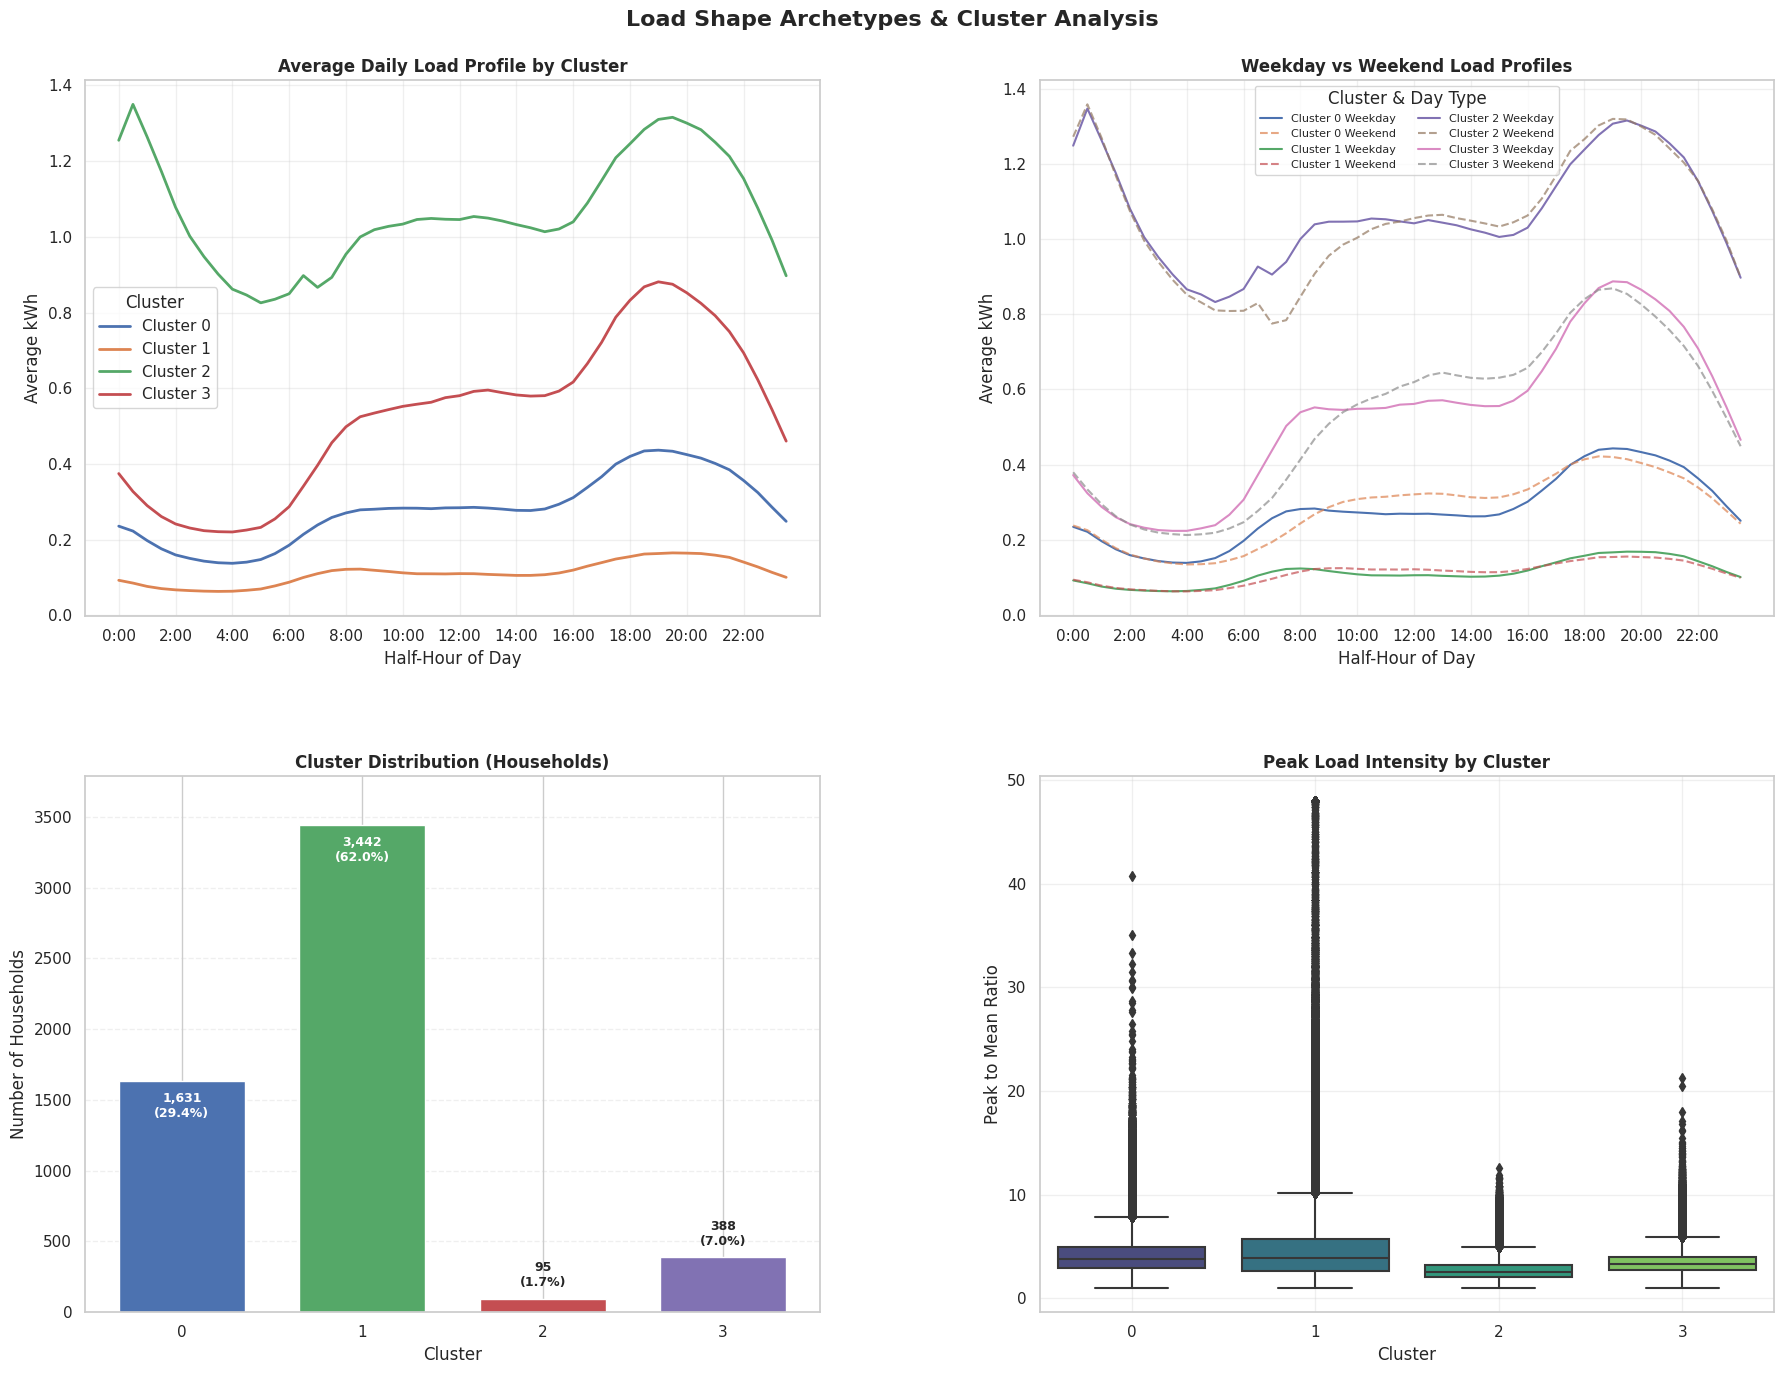

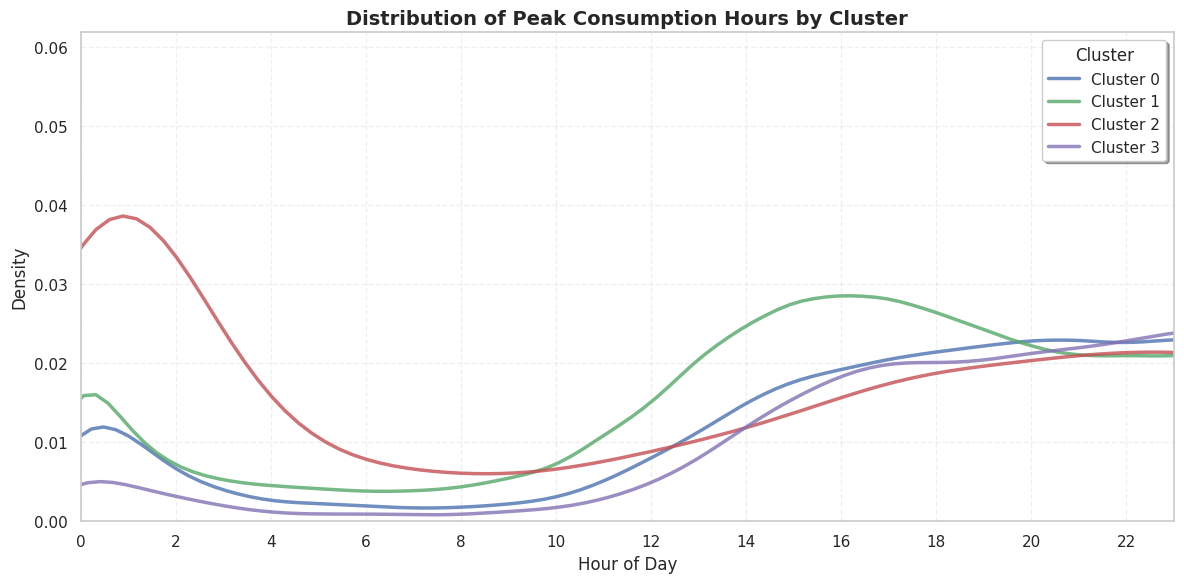

✅ Load Shape Analysis Complete!


{0: array([0.23575498, 0.22280265, 0.19769138, 0.17593789, 0.15979682,
        0.15060541, 0.1433344 , 0.13907243, 0.13758874, 0.14066558,
        0.14760712, 0.16322418, 0.18548119, 0.21402968, 0.23882498,
        0.25864464, 0.2707312 , 0.27882063, 0.2804737 , 0.28261992,
        0.2833862 , 0.2831838 , 0.28192022, 0.28401083, 0.2843744 ,
        0.28545853, 0.2835601 , 0.28084025, 0.27751616, 0.27705082,
        0.281079  , 0.2936721 , 0.31107315, 0.3381014 , 0.36623737,
        0.3996242 , 0.4199485 , 0.43439895, 0.43649462, 0.43364763,
        0.42477894, 0.4154423 , 0.40143448, 0.38469437, 0.35643625,
        0.32462925, 0.285887  , 0.24849746], dtype=float32),
 1: array([0.09274522, 0.08537387, 0.07655893, 0.0707685 , 0.06746602,
        0.06550916, 0.06406038, 0.06335513, 0.06381197, 0.06630179,
        0.06973705, 0.07788552, 0.08769649, 0.10013185, 0.11027042,
        0.11829277, 0.12169635, 0.12227496, 0.11916944, 0.1159495 ,
        0.1124549 , 0.11000384, 0.10987556, 0.109

In [13]:
plot_load_shape_analysis(df_features, cluster_col="kmeans_cluster")

### 📊 Cluster Stability Analysis — Interpretation

This section evaluates how consistently households remain in the same behavioral archetype (cluster) across time, offering insight into long-term routine vs. variability.

#### 1. Distribution of Stability Scores
The distribution shows that most households exhibit relatively high cluster stability, with scores concentrated between 0.7 and 1.0. This suggests that energy behavior is generally stable across months. However, a noticeable minority exhibits lower scores (< 0.5), indicating frequent transitions between load-shape archetypes. These users may reflect shifting occupancy, lifestyle changes, or behavioral inconsistency. The mean and median stability hover around 0.76, meaning that the average household changes clusters once every 4–5 months.

#### 2. Stability by ACORN Group
Stability varies significantly by socio-economic status. Affluent groups (e.g., ACORN-A, ACORN-B) maintain more stable consumption patterns, while less affluent or transitional groups (e.g., ACORN-F, ACORN-H) display greater variability. This was statistically confirmed via a Kruskal-Wallis H-test (p < 0.0001), rejecting the null hypothesis of equal distributions across groups. These findings suggest that routine-driven households are more predictable, which is relevant for demand response targeting and reliability.

#### 3. Stability vs. Consumption Level
When comparing average daily kWh to stability, there appears to be a mild inverse trend: higher-consuming households tend to show more instability in cluster assignments. This may be due to higher appliance ownership, load diversity, or temporal variability (e.g., heating/cooling loads, EV charging). In contrast, low-consumption users typically display consistent baseline behavior, resulting in more stable cluster trajectories.

#### 4. Peak Usage and Behavioral Switching
Although not shown directly in this figure, earlier cluster summaries indicate that different clusters are characterized by distinct **peak load positions** (e.g., early morning, evening). Households that switch clusters frequently may also be undergoing changes in peak behavior, such as shifting work schedules or seasonal appliance usage. This suggests that **peak timing stability** could be an important secondary metric, especially for time-sensitive tariff design or grid flexibility programs.

---

Taken together, these insights highlight the multidimensional nature of behavioral evolution, linking **socio-demographics**, **consumption volume**, and **temporal load-shape dynamics** to cluster consistency over time.


In [14]:
from visualization.clustering.weather_impact import (
    plot_weather_impact_analysis,
    plot_seasonal_weather_patterns,
    plot_extreme_weather_impact
)

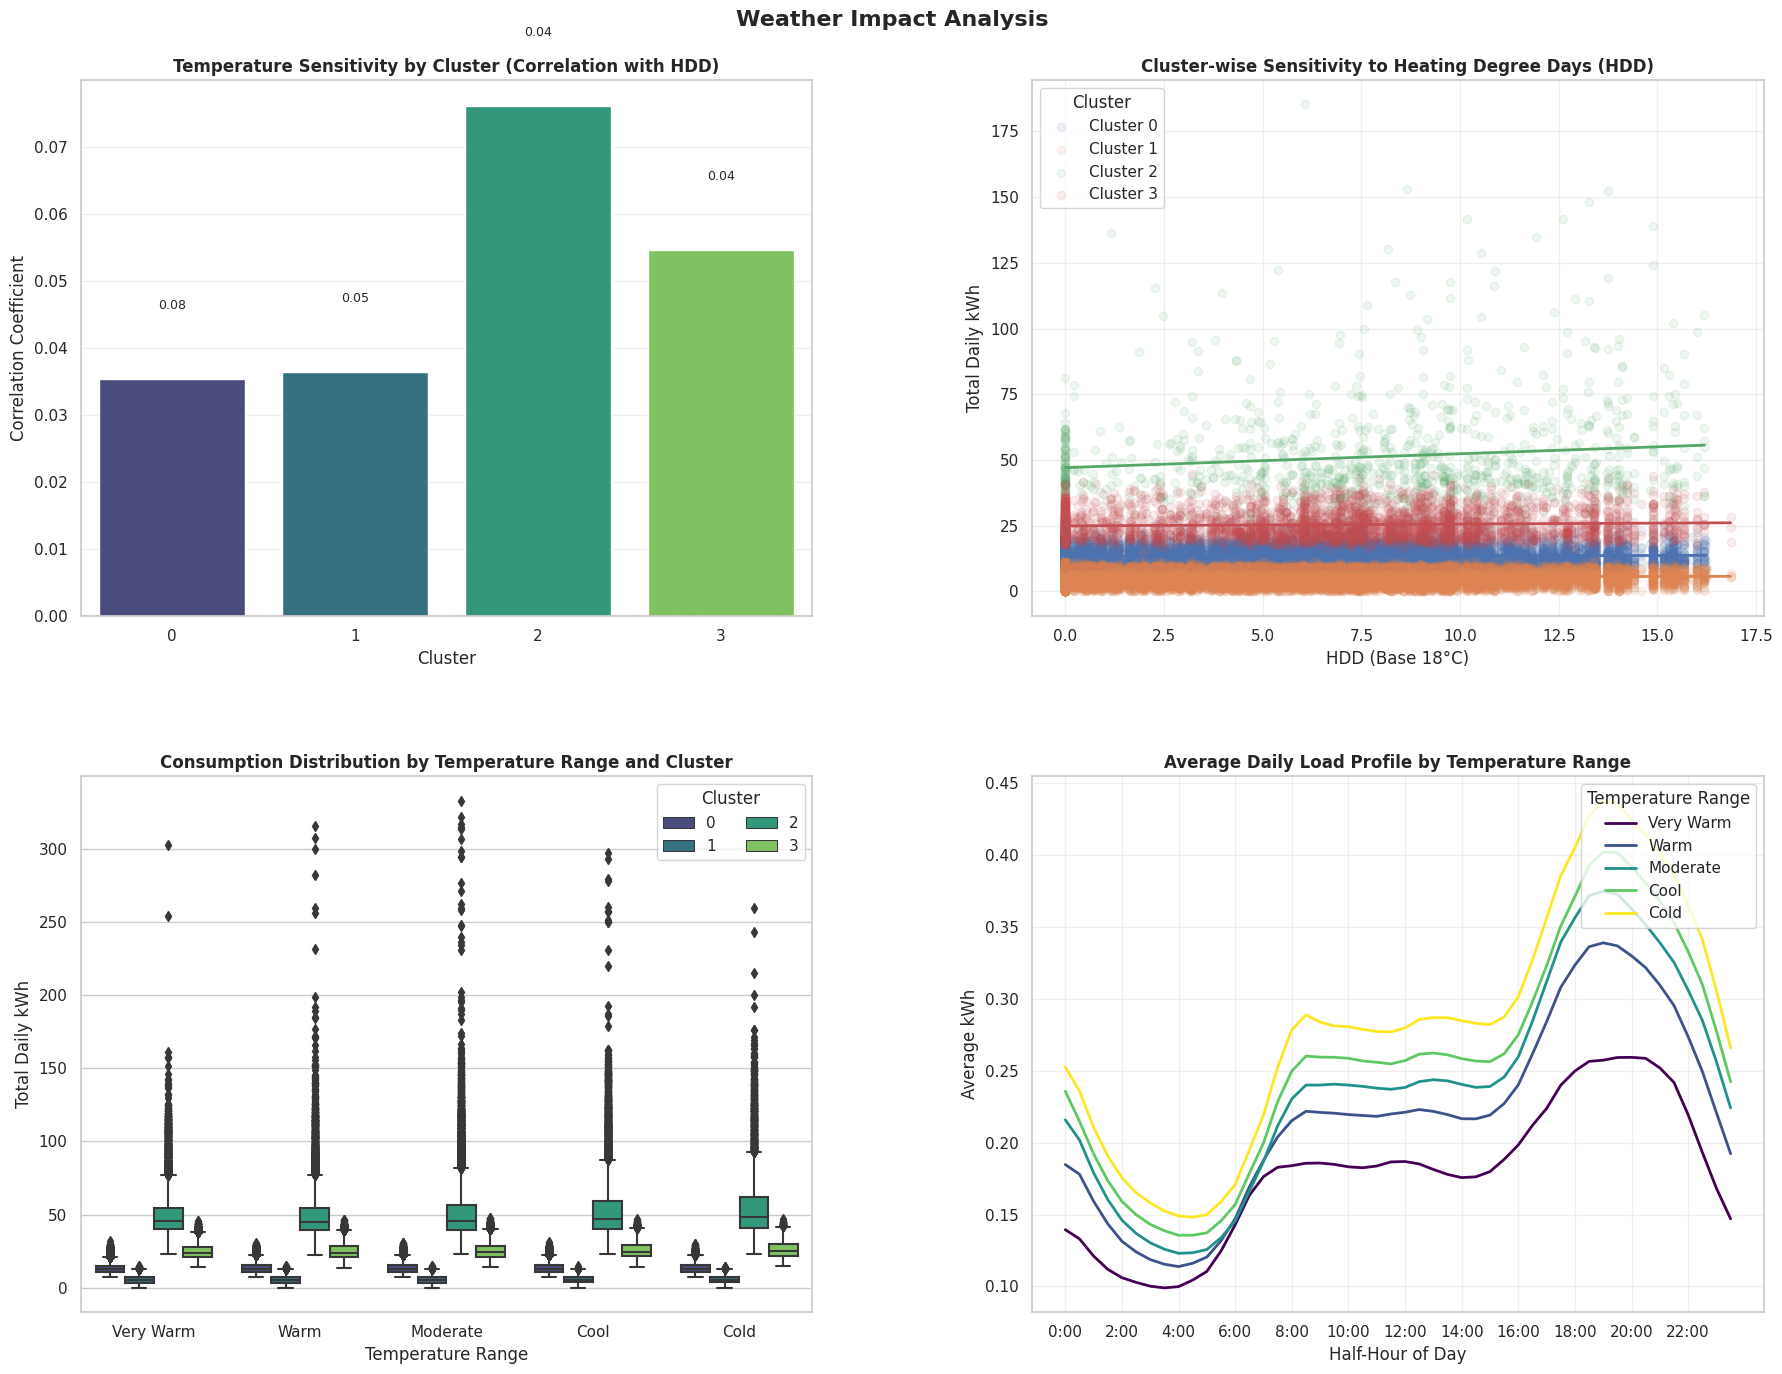

✅ Weather Impact Analysis Complete!


In [15]:
plot_weather_impact_analysis(df_features, cluster_col="kmeans_cluster") 

### 🌡️ Weather Impact Analysis — Interpretation

This section examines how temperature—particularly colder conditions measured via Heating Degree Days (HDD)—modulates electricity consumption across clusters and time.

#### 1. Cluster-Wise Temperature Sensitivity
The leftmost bar plot quantifies each cluster’s temperature sensitivity using correlation between HDD and total daily kWh. Cluster 2 stands out with the highest temperature sensitivity (~0.08), suggesting members in this group significantly increase consumption in colder conditions—potentially due to electric heating systems or longer occupancy during winter. Other clusters exhibit lower but still positive sensitivity, indicating some responsiveness to outdoor temperature drops.

The accompanying scatterplot with linear trend lines (right) visually confirms this pattern: Cluster 2 shows a stronger upward slope with HDD, while Clusters 0 and 1 remain mostly flat. Cluster 3 also demonstrates modest responsiveness.

#### 2. Consumption by Temperature Range
The lower-left boxplot illustrates how consumption varies across temperature bands (Very Warm → Cold). Median consumption clearly rises as weather gets colder, and this pattern is strongest for Cluster 2, reinforcing its weather-sensitive nature. This suggests Cluster 2 users likely operate more heating-related loads in cold weather, while Clusters 0 and 1 remain less affected.

#### 3. Load Shape Profiles by Temperature Range
The final line plot (bottom right) shows how daily load shapes shift under different temperature regimes. On cold days, households exhibit a distinct double-peak profile with a sharper and earlier morning rise and a stronger evening peak—possibly reflecting greater heating usage during wake-up and evening routines. On very warm days, curves flatten, and peak intensity diminishes, consistent with reduced heating demand. These findings reveal that both total usage and intra-day load patterns evolve meaningfully with temperature.

---

Together, these plots confirm that colder weather increases both the volume and temporal concentration of residential electricity use—especially in specific behavioral clusters like Cluster 2. These insights are critical for seasonally adaptive demand response programs and winter peak load planning.


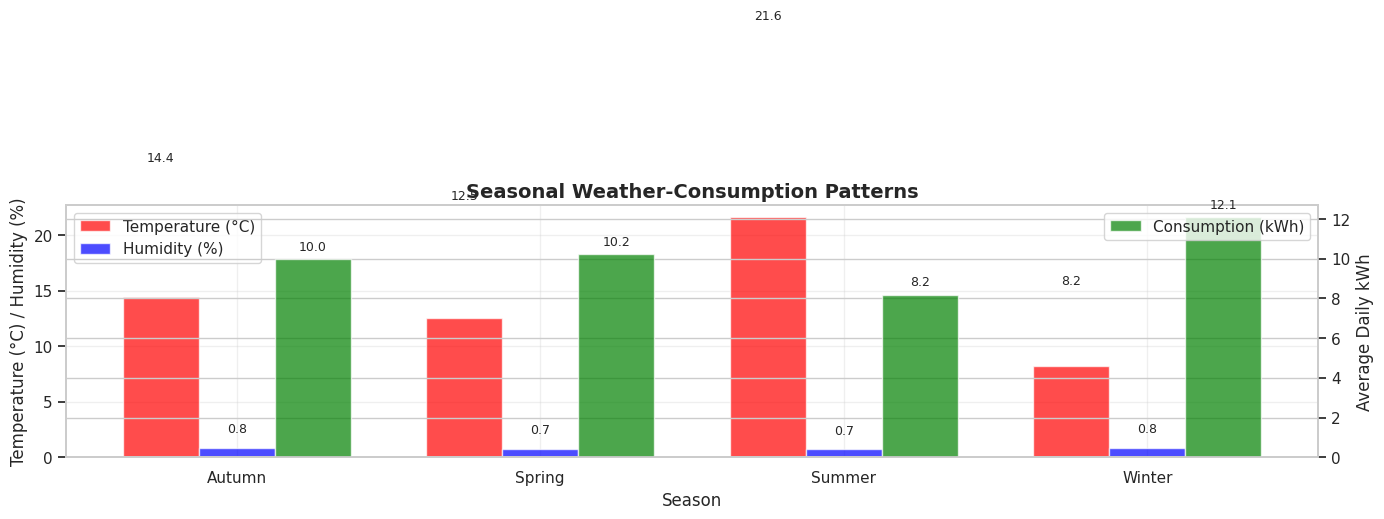

✅ Seasonal Weather Patterns Analysis Complete!


<Figure size 1400x800 with 0 Axes>

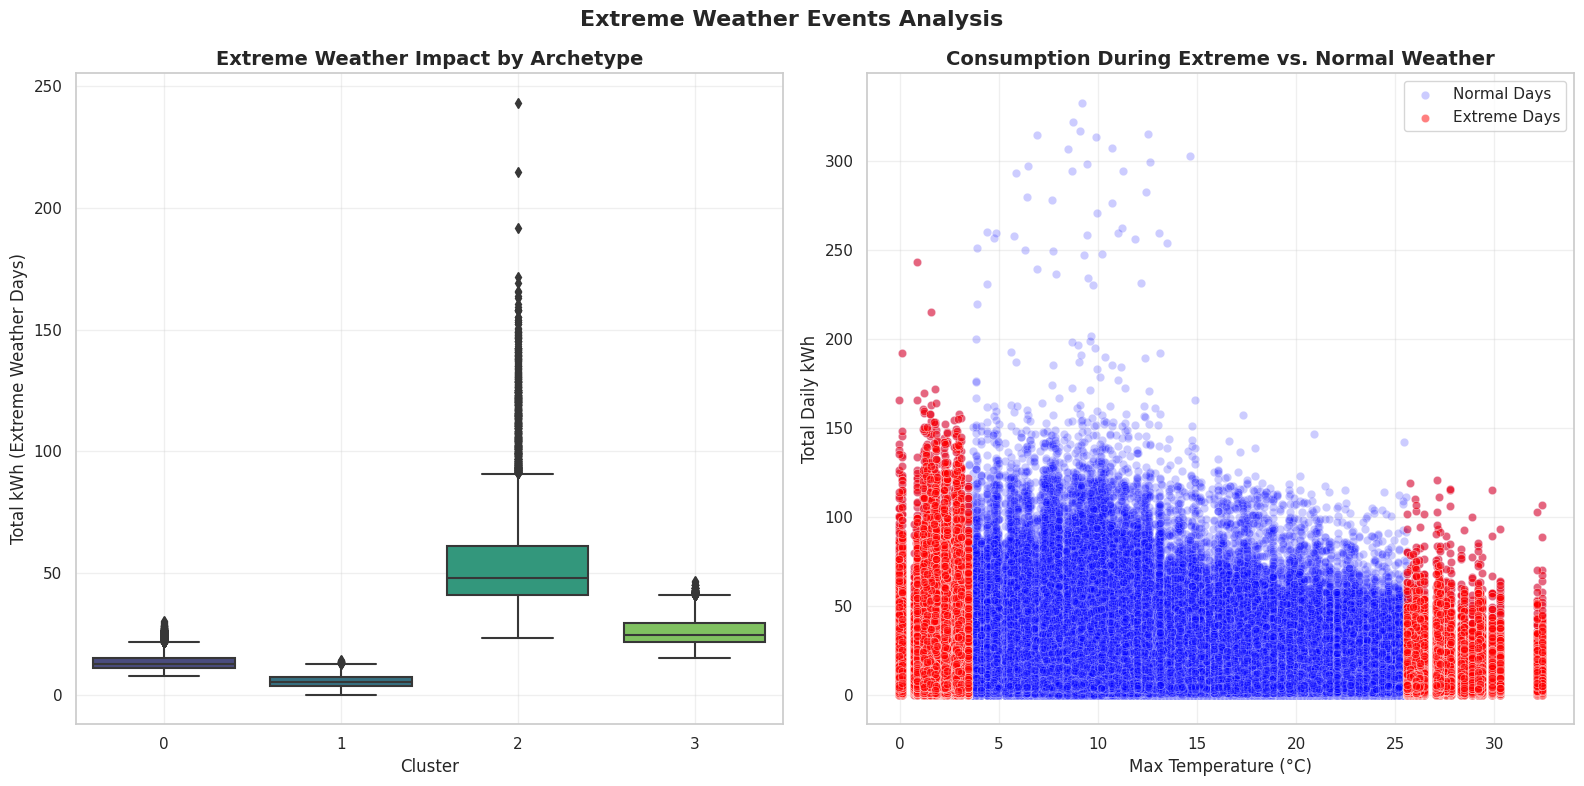

✅ Extreme Weather Impact Analysis Complete!


In [16]:
plot_seasonal_weather_patterns(df_features, cluster_col="kmeans_cluster") 
plot_extreme_weather_impact(df_features, cluster_col="kmeans_cluster") 

### 🌦️ Seasonal & Extreme Weather Impact — Interpretation

This section examines how seasonal changes and extreme temperature events influence electricity consumption patterns, both across the general population and within specific behavioral archetypes.

#### 1. Seasonal Weather-Consumption Patterns
The grouped bar plot shows clear seasonal variation in electricity consumption. Despite higher temperatures in summer, winter exhibits the highest average daily electricity usage (~12.1 kWh), aligned with lower temperatures (~8.2°C) and higher humidity. This suggests that **cold-season heating loads** are a dominant driver of residential demand. Spring and autumn show comparable patterns (~10 kWh), while summer shows the lowest average consumption (~8.2 kWh), despite being the warmest season. These findings highlight **seasonal asymmetry** in thermal comfort energy usage.

#### 2. Extreme Weather Impact by Archetype
The boxplot shows that certain clusters are more sensitive to extreme weather days (defined by very high or very low temperatures). Specifically, **Cluster 2**, previously identified as highly temperature-sensitive, shows markedly higher energy usage during extreme weather events—both in terms of median and variance. Clusters 0 and 1 remain largely stable, suggesting more resilient or less heating-dependent profiles.

#### 3. Consumption During Extreme vs. Normal Days
The scatterplot further distinguishes consumption patterns by daily max temperature. **Red points** represent extreme weather days, while **blue points** are normal days. Red clusters are denser at the low and high ends of the temperature scale (≤ 1st and ≥ 99th percentiles). Notably, red points often rise above the blue baseline, especially during low-temperature periods, reinforcing the **amplifying effect of cold extremes** on energy demand. This pattern becomes especially critical when planning for **grid resilience, demand response, and heating electrification**.

---

These insights validate the impact of both gradual seasonal transitions and sudden extremes on residential demand, with heterogeneity across consumer segments. This motivates **season-aware and cluster-aware forecasting models**, as well as differentiated demand-side interventions.


In [17]:
from visualization.clustering.socioeconomic import (
    cluster_profile_summary,
    plot_acorn_distribution,
    plot_socioeconomic_intervention_analysis
)

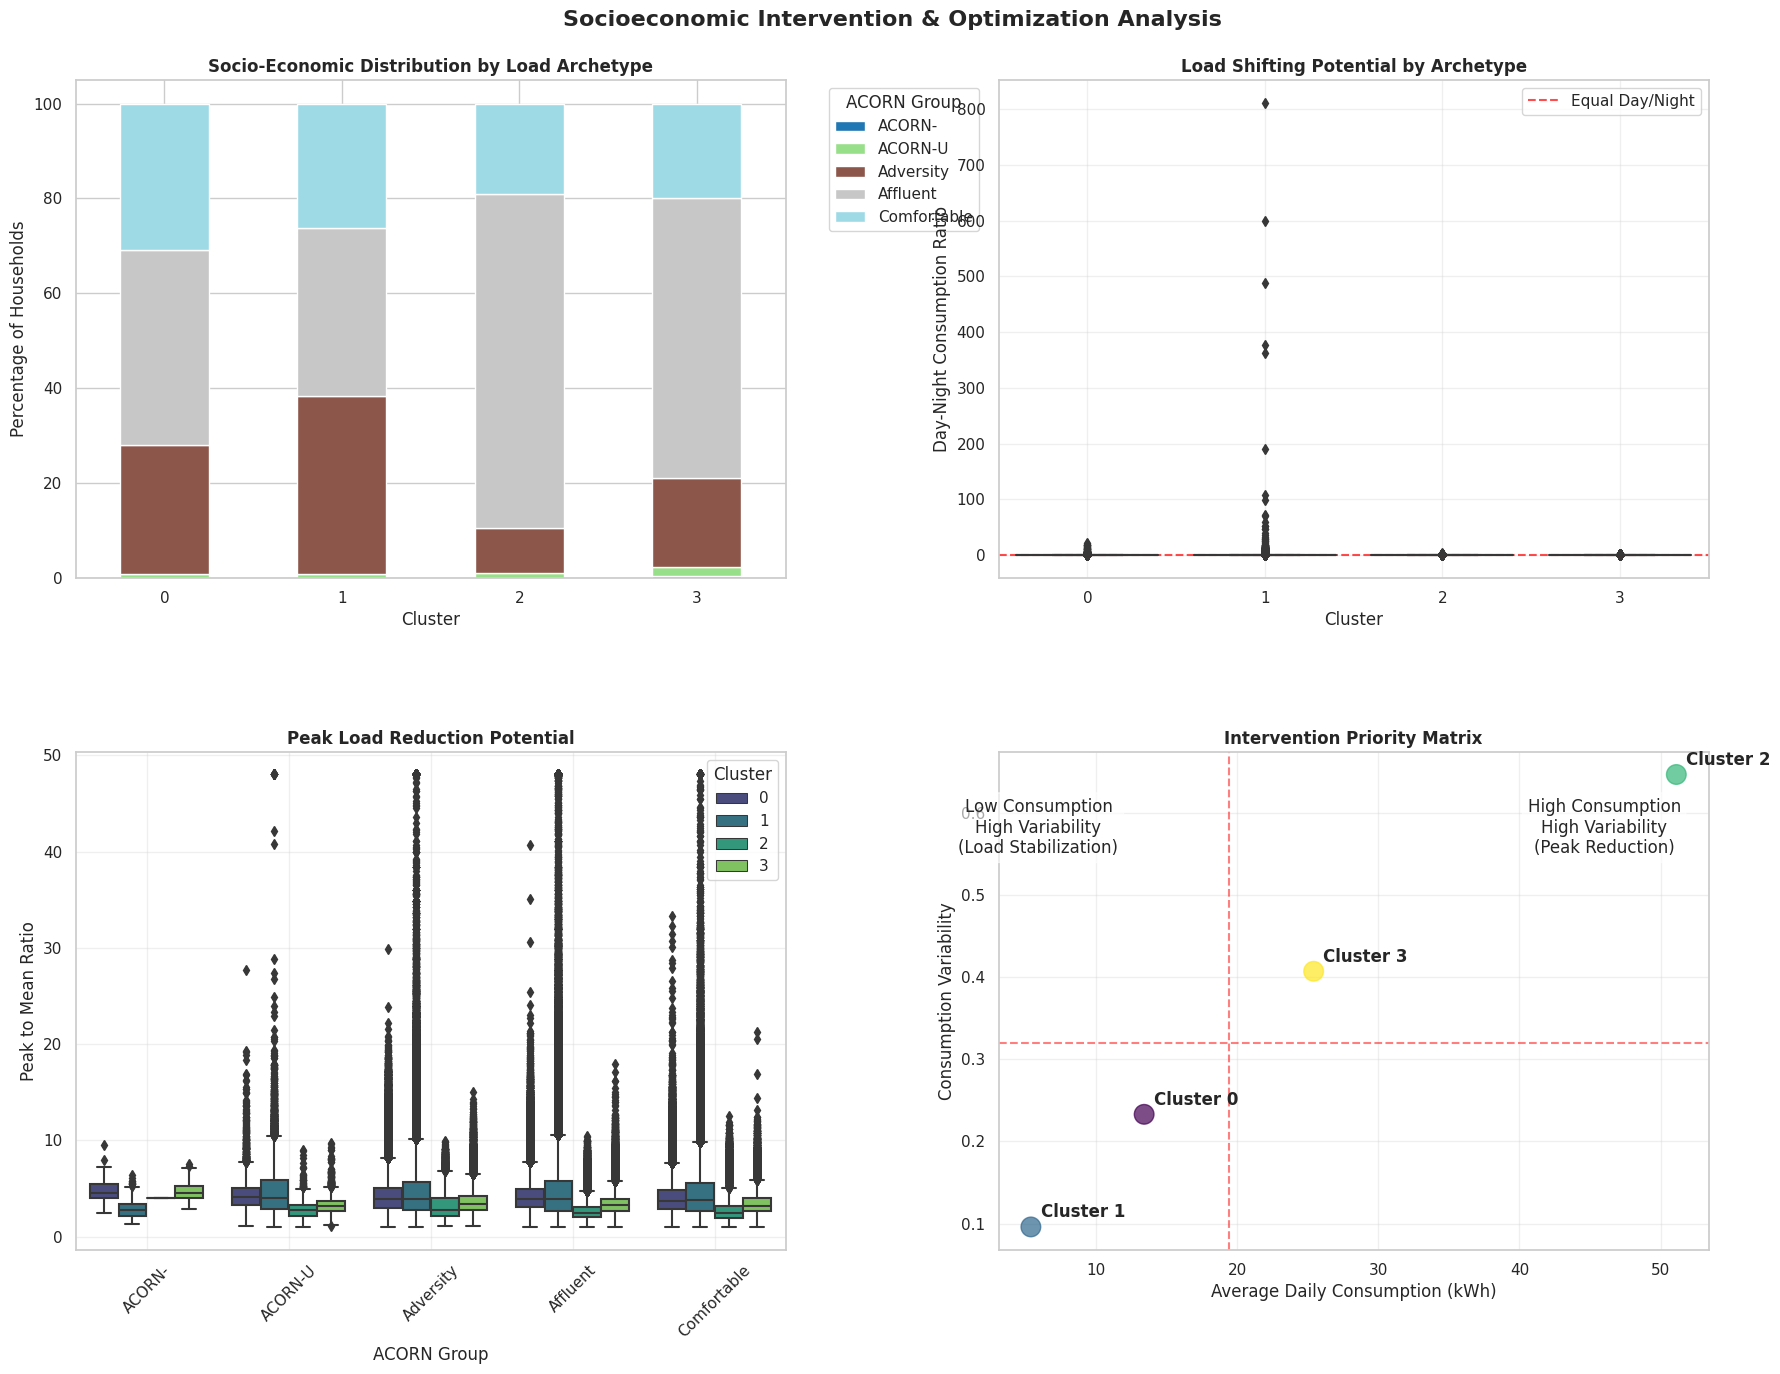

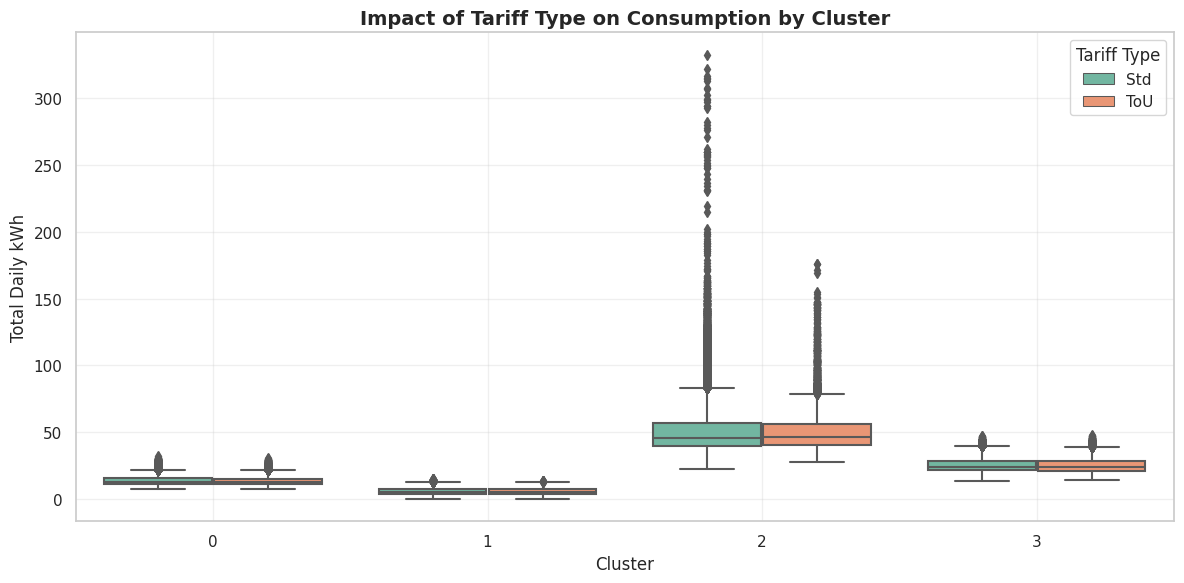

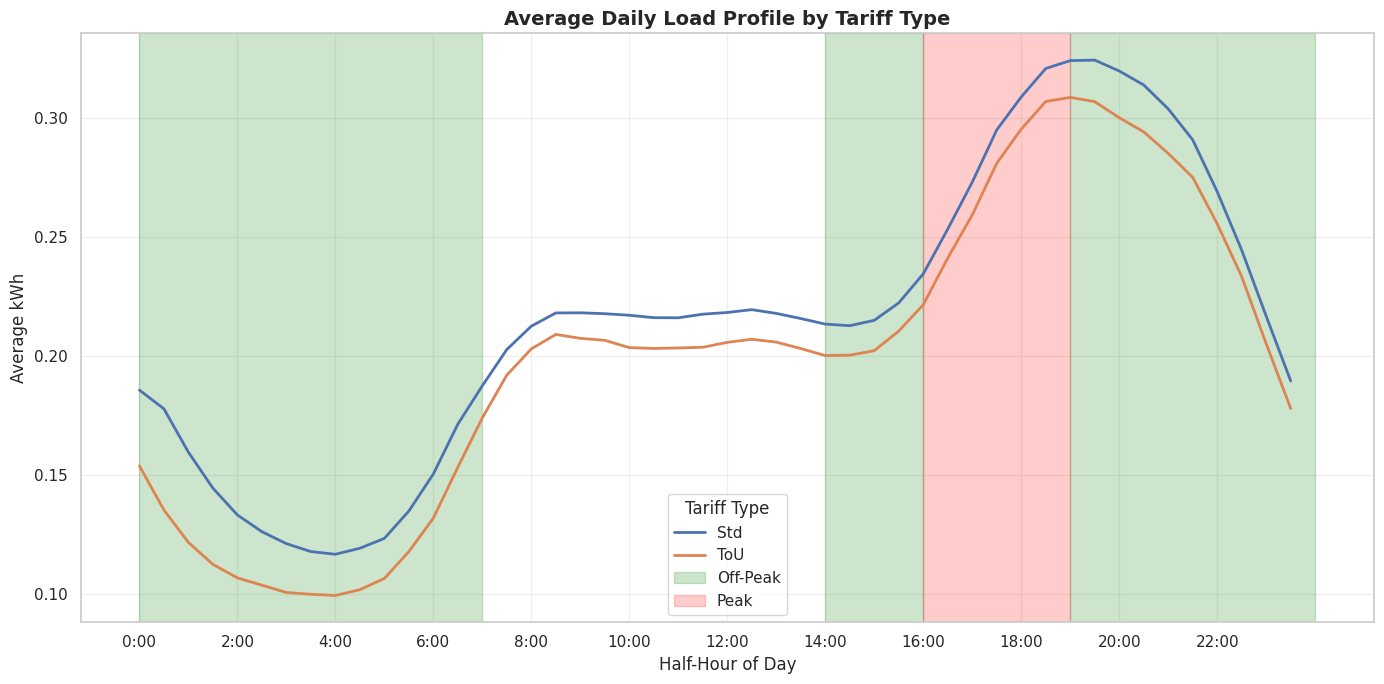

✅ Socioeconomic Intervention Analysis Complete!


LCLid  kmeans_cluster Acorn_grouped
95696    MAC000002               0      Affluent
2797754  MAC000003               2     Adversity
3175096  MAC000004               1      Affluent
2768487  MAC000005               1      Affluent
1442819  MAC000006               1     Adversity
...            ...             ...           ...
2214710  MAC005561               1     Adversity
845769   MAC005562               1   Comfortable
3143116  MAC005564               1     Adversity
3374289  MAC005566               2      Affluent
1252440  MAC005567               1     Adversity

[5556 rows x 3 columns]

In [18]:
plot_socioeconomic_intervention_analysis(df_features, cluster_col="kmeans_cluster")

### 🧭 Socioeconomic Intervention & Optimization — Interpretation

This section explores how load-shape archetypes vary by socio-economic context and tariff types, and how these insights can guide demand-side interventions.

#### 1. Socio-Economic Distribution by Archetype
The leftmost stacked bar shows that clusters are not evenly distributed across ACORN groups. For instance, Clusters 0 and 1 include more ‘Affluent’ and ‘Comfortable’ households, while Cluster 2 contains a disproportionately high share of ‘Adversity’ users. This stratification suggests that behavioral archetypes partially reflect socio-demographic constraints, which should be considered when designing equitable interventions.

#### 2. Load Shifting Potential (Day/Night Ratio)
The second panel shows wide variation in day-to-night load ratios across clusters. Some users exhibit extremely high ratios (outliers in Cluster 1), suggesting sharply peaked daytime loads, potentially indicating high shifting potential if engaged through tariffs or automation. Most clusters show ratios >1, meaning daytime usage dominates—justifying peak shaving efforts.

#### 3. Peak Load Reduction Potential
The third plot breaks down peak-to-mean ratios by ACORN group and cluster. Cluster 2 again stands out, with both a high median and wide spread in peakiness—indicating significant potential for **demand flattening** interventions. Some ACORN groups (e.g., ‘Adversity’, ‘ACORN-U’) show high peak values, highlighting vulnerability to time-of-use exposure and the need for protective or incentivized strategies.

#### 4. Intervention Priority Matrix
This quadrant-based chart helps triage intervention strategies. Cluster 2, located in the top-right quadrant, has both **high average consumption and high variability**, making it a prime candidate for peak demand reduction and load forecasting refinement. Cluster 1, with low variability and consumption, represents a low-risk, low-reward segment best suited for passive monitoring.

#### 5. Tariff Impact on Clustered Consumption
The boxplot shows that ToU (Time-of-Use) tariffs have slightly reduced consumption in high-usage Cluster 2, suggesting some degree of demand response. However, other clusters show little separation between Std and ToU, indicating variable effectiveness depending on the load profile.

#### 6. Load Shape by Tariff Type
The final plot confirms that households on ToU tariffs shift usage away from peak hours (marked in red, e.g., 16:00–19:00). The evening peak for ToU users is flattened compared to those on standard tariffs. This validates tariff-induced behavioral change and supports expanded ToU rollout in clusters where responsiveness is already observable.

---

Together, these plots support the development of **cluster-targeted** and **equity-aware** energy interventions, including tariff tuning, automation rollout, and educational outreach tailored to behavioral and demographic contexts.


🔧 Preparing features for plotting...
✅ Created 'temp_impact' as temperature-consumption correlation
🎯 Feature preparation complete! DataFrame shape: (3469317, 134)

Cluster Profile Summary:

                total_kwh        peak_hour                    stdorToU  \
                     mean    std      mean most_frequent most_frequent   
kmeans_cluster                                                           
0               13.400000   3.01     30.09          37.0           Std   
1                5.370000   2.37     28.09          37.0           Std   
2               51.110001  19.09     24.46           0.0           Std   
3               25.410000   5.19     31.39          38.0           Std   

               Acorn_grouped daily_variability  
               most_frequent              mean  
kmeans_cluster                                  
0                   Affluent              0.23  
1                   Affluent              0.10  
2                   Affluent              0.6

<Figure size 1200x600 with 0 Axes>

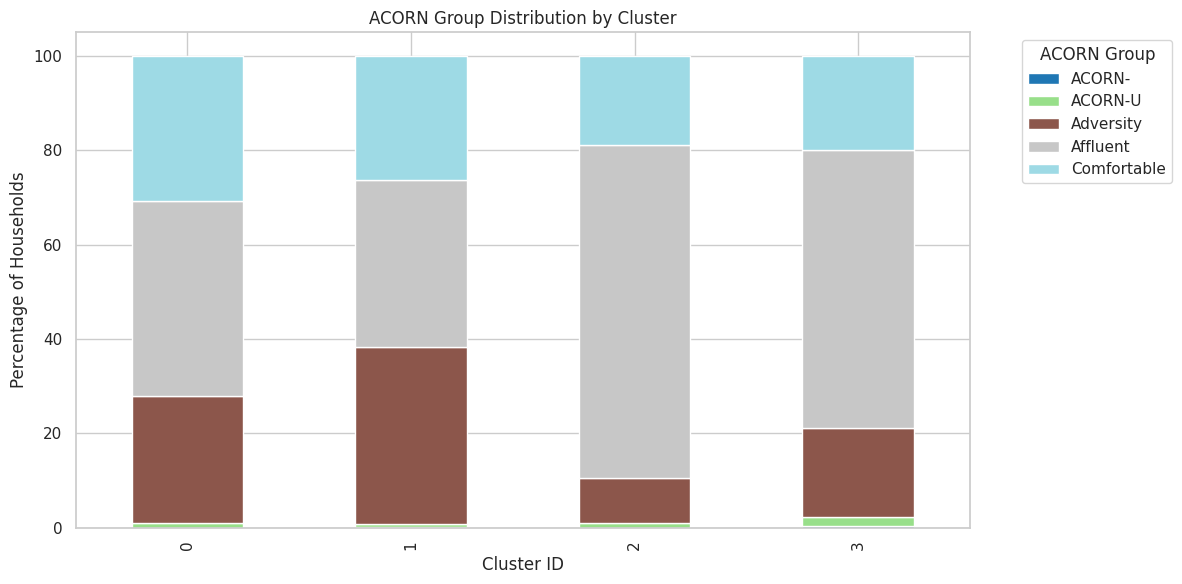

Acorn_grouped     ACORN-   ACORN-U  Adversity   Affluent  Comfortable
kmeans_cluster                                                       
0               0.000000  0.858369  27.038627  41.324341    30.778663
1               0.029053  0.755375  37.478210  35.444509    26.292853
2               0.000000  1.052632   9.473684  70.526316    18.947368
3               0.257732  2.061856  18.814433  59.020619    19.845361

In [19]:
# Get cluster profiles
profile_data = cluster_profile_summary(df_features, cluster_col="kmeans_cluster")

# Plot ACORN group distribution
plot_acorn_distribution(df_features, cluster_col="kmeans_cluster")

In [20]:
from visualization.clustering.temporal import (
    plot_cluster_evolution,
    plot_pattern_evolution_analysis,
    plot_pattern_stability_analysis,
    plot_seasonal_load_signature_grid,
    plot_cluster_switching_analysis,
    plot_cluster_timelines
)

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_cluster_switching_analysis(df_hh, cluster_col="cluster"):
    """
    Analyze and plot cluster switching behavior
    Returns the switch counts for use in timeline plotting
    """
    # Prepare features if needed
    df = df_hh
    
    # Calculate switching statistics
    df_switch = df[["LCLid", "day", cluster_col]].dropna()
    df_switch["day"] = pd.to_datetime(df_switch["day"])
    df_switch = df_switch.sort_values(["LCLid", "day"])
    
    # Compute switches for each user
    switch_counts = {}
    
    for lclid, user_df in df_switch.groupby("LCLid"):
        if len(user_df) <= 1:
            continue
            
        user_df = user_df.sort_values("day")
        
        # Create shifted column to compare with previous cluster
        user_df["prev_cluster"] = user_df[cluster_col].shift(1)
        
        # Count switches (when current != previous)
        switches = (user_df[cluster_col] != user_df["prev_cluster"]).sum()
        total_days = len(user_df)
        
        # Only count users with at least 2 records
        if total_days > 1:
            switch_rate = switches / (total_days - 1)  # -1 because first day has no previous
            switch_counts[lclid] = {
                "switches": switches,
                "total_days": total_days,
                "switch_rate": switch_rate
            }
    
    # Convert to DataFrame for analysis
    switch_df = pd.DataFrame.from_dict(switch_counts, orient="index")
    
    # Plot switch rate distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(switch_df["switch_rate"], bins=20, kde=True)
    plt.axvline(switch_df["switch_rate"].mean(), color='r', linestyle='--', 
               label=f"Mean: {switch_df['switch_rate'].mean():.2f}")
    plt.axvline(switch_df["switch_rate"].median(), color='g', linestyle='--', 
               label=f"Median: {switch_df['switch_rate'].median():.2f}")
    plt.title("Distribution of Cluster Switching Rates")
    plt.xlabel("Switch Rate (Proportion of Days with Cluster Change)")
    plt.ylabel("Count of Households")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot relationship between total days and switches
    plt.figure(figsize=(10, 6))
    plt.scatter(switch_df["total_days"], switch_df["switches"], alpha=0.3)
    plt.title("Relationship Between Observation Period and Number of Switches")
    plt.xlabel("Total Days Observed")
    plt.ylabel("Number of Cluster Switches")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # If socioeconomic data available, analyze switch rates by ACORN group
    if "Acorn_grouped" in df.columns:
        acorn_switch = df[["LCLid", "Acorn_grouped"]].drop_duplicates().set_index("LCLid")
        switch_acorn = switch_df.join(acorn_switch, how="inner")
        
        if not switch_acorn.empty and "Acorn_grouped" in switch_acorn.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=switch_acorn, x="Acorn_grouped", y="switch_rate")
            plt.title("Cluster Switching Rate by ACORN Group")
            plt.xlabel("ACORN Group")
            plt.ylabel("Switch Rate")
            plt.grid(True, axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    print(f"Average switch rate: {switch_df['switch_rate'].mean():.3f}")
    print(f"Median switch rate: {switch_df['switch_rate'].median():.3f}")
    print(f"Percentage of stable households (switch rate < 0.1): {(switch_df['switch_rate'] < 0.1).mean() * 100:.1f}%")
    print(f"Percentage of volatile households (switch rate > 0.5): {(switch_df['switch_rate'] > 0.5).mean() * 100:.1f}%")
    
    return switch_df

def plot_cluster_timelines(df_hh, switch_counts, top_n=5, cluster_col="cluster"):
    """
    Plot cluster assignment timelines for the most volatile households
    """
    # Prepare features if needed
    df = df_hh
    
    # Sort households by switch rate
    if isinstance(switch_counts, pd.DataFrame) and "switch_rate" in switch_counts.columns:
        volatile_users = switch_counts.sort_values("switch_rate", ascending=False).head(top_n).index.tolist()
    else:
        print("⚠️ Invalid switch_counts provided. Using random households instead.")
        volatile_users = np.random.choice(df["LCLid"].unique(), size=min(top_n, len(df["LCLid"].unique())), replace=False)
    
    # Plot timelines for each user
    for lclid in volatile_users:
        df_user = df[df["LCLid"] == lclid].sort_values("day")
        
        if len(df_user) <= 1:
            continue
        
        plt.figure(figsize=(12, 4))
        plt.plot(df_user["day"], df_user[cluster_col], 
                marker='o', linestyle='-', markersize=3)
        plt.title(f"Cluster Assignment Timeline — LCLid: {lclid}")
        plt.xlabel("Date")
        plt.ylabel("Cluster")
        plt.yticks(sorted(df_user[cluster_col].unique()))
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

def plot_cluster_evolution(df_hh, cluster_col="cluster"):
    """
    Plot the evolution of cluster distributions over time
    """
    # Prepare features if needed
    df = df_hh
    
    plt.figure(figsize=(14, 6))
    df["day"] = pd.to_datetime(df["day"])
    df["month"] = df["day"].dt.to_period("M")
    monthly_counts = df[df[cluster_col].notna()].groupby(
        ["month", cluster_col]).size().unstack(fill_value=0)
    monthly_share = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)
    monthly_share.plot(kind="bar", stacked=True, figsize=(14, 5), colormap="Set2")
    plt.title("Monthly Distribution of Clusters (Behavioral Archetypes Over Time)")
    plt.xlabel("Month")
    plt.ylabel("Share of Active Household-Days")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

def plot_pattern_stability_analysis(df_hh, cluster_col="cluster"):
    """
    Analyze the stability of consumption patterns over time
    Shows how patterns evolve month-by-month for each cluster
    """
    # Prepare features if needed
    df = df_hh
    
    # Check if we have time-based data
    if "day" not in df.columns:
        print("⚠️ Day column not found. Unable to perform pattern stability analysis.")
        return None
    
    # Ensure day is datetime
    df["day"] = pd.to_datetime(df["day"])
    
    # Create month and year columns
    df["month"] = df["day"].dt.month
    df["month_name"] = df["day"].dt.strftime('%b')
    
    # Filter data
    df_stab = df[df[cluster_col].notna()].copy()
    df_stab[cluster_col] = df_stab[cluster_col].astype(int)
    
    # Monthly average consumption by cluster
    plt.figure(figsize=(14, 7))
    
    # Calculate monthly averages
    monthly_avg = df_stab.groupby([cluster_col, "month"])["total_kwh"].mean().unstack()
    
    # Transpose for better visualization (clusters as columns, months as rows)
    monthly_avg_T = monthly_avg.T
    
    # Create month names for better x-axis labels
    month_names = {i: pd.Timestamp(2023, i, 1).strftime('%b') for i in range(1, 13)}
    monthly_avg_T.index = monthly_avg_T.index.map(month_names)
    
    # Plot each cluster's pattern stability
    for cluster in sorted(df_stab[cluster_col].unique()):
        if cluster in monthly_avg_T.columns:
            plt.plot(monthly_avg_T.index, monthly_avg_T[cluster], 
                   marker='o', label=f"Cluster {cluster}", linewidth=2)
    
    plt.title("Pattern Stability Over Time", fontsize=14, fontweight='bold')
    plt.xlabel("Month")
    plt.ylabel("Average Daily kWh")
    plt.legend(title="Cluster")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Seasonal pattern variability
    if "season" in df_stab.columns:
        plt.figure(figsize=(14, 7))
        sns.boxplot(data=df_stab, x=cluster_col, y="daily_variability" if "daily_variability" in df_stab.columns 
                   else "total_kwh", hue="season")
        plt.title("Pattern Variability by Season", fontsize=14, fontweight='bold')
        plt.xlabel("Cluster")
        plt.ylabel("Daily Variability" if "daily_variability" in df_stab.columns else "Total Daily kWh")
        plt.legend(title="Season")
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return df_stab

def plot_seasonal_load_signature_grid(df_hh, cluster_col="cluster"):
    """
    Plot a 2×2 grid of temporal evolution visualizations:
    - Seasonal Load Signature Evolution (daily kWh by cluster over months)
    - Seasonal Pattern Evolution by Cluster (half-hourly patterns by season)
    - Pattern Stability Over Time (consistency of patterns)
    - Pattern Variability by Season (daily variability measures)
    """
    # Prepare features if needed
    df = df_hh
    
    # Check for required columns
    if "day" not in df.columns:
        print("⚠️ Day column not found. Unable to perform seasonal analysis.")
        return None
    
    # Ensure day is datetime
    df["day"] = pd.to_datetime(df["day"])
    df["month"] = df["day"].dt.month
    df["month_name"] = df["day"].dt.strftime('%b')
    
    if "season" not in df.columns and "month" in df.columns:
        # Create season if it doesn't exist
        season_map = {
            1: "Winter", 2: "Winter", 3: "Spring", 4: "Spring",
            5: "Spring", 6: "Summer", 7: "Summer", 8: "Summer",
            9: "Autumn", 10: "Autumn", 11: "Autumn", 12: "Winter"
        }
        df["season"] = df["month"].map(season_map)
    
    # Filter data
    df_plot = df[df[cluster_col].notna()].copy()
    df_plot[cluster_col] = df_plot[cluster_col].astype(int)
    
    # Create 2×2 grid layout
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Seasonal Load Signature Evolution (top-left)
    # Calculate monthly average by cluster
    monthly_data = df_plot.groupby([df_plot["day"].dt.to_period("M"), cluster_col])["total_kwh"].mean().unstack()
      # Plot monthly evolution
    for cluster in sorted(df_plot[cluster_col].unique()):
        if cluster in monthly_data.columns:
            ax1.plot(range(len(monthly_data.index)), monthly_data[cluster], 
                   marker='o', markersize=3, label=f"Cluster {cluster}", linewidth=2)
    
    # Format x-axis with month labels
    if len(monthly_data.index) > 0:
        month_labels = [str(idx).split("-")[1] for idx in monthly_data.index]
        
        # Show a subset of labels if there are many months
        if len(month_labels) > 12:
            step = len(month_labels) // 12 + 1
            # Use the same step for both ticks and labels to ensure they match
            tick_positions = range(0, len(month_labels), step)
            ax1.set_xticks(tick_positions)
            ax1.set_xticklabels([month_labels[i] for i in tick_positions])
        else:
            ax1.set_xticks(range(len(month_labels)))
            ax1.set_xticklabels(month_labels)
            
    ax1.set_title("Seasonal Load Signature Evolution", fontsize=12, fontweight='bold')
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Mean Daily kWh")
    ax1.legend(title="Cluster")
    ax1.grid(True, alpha=0.3)
      # 2. Seasonal Pattern Evolution for a specific cluster (top-right)
    # Select a representative cluster (middle cluster or cluster 0)
    clusters = sorted(df_plot[cluster_col].unique())
    representative_cluster = clusters[len(clusters) // 2] if len(clusters) > 0 else 0
    
    # Define half-hourly columns
    hh_cols = [f"hh_{i}" for i in range(48)]
    
    # Get seasonal patterns for the representative cluster
    if "season" in df_plot.columns and all(col in df_plot.columns for col in hh_cols):
        cluster_data = df_plot[df_plot[cluster_col] == representative_cluster]
        
        for season in sorted(cluster_data["season"].unique()):
            season_data = cluster_data[cluster_data["season"] == season]
            if len(season_data) > 0:
                avg_pattern = season_data[hh_cols].mean().values
                ax2.plot(range(48), avg_pattern, label=season, linewidth=2)
        
        ax2.set_title(f"Seasonal Pattern Evolution - Cluster {representative_cluster}", 
                     fontsize=12, fontweight='bold')
        ax2.set_xlabel("Half-Hour Interval")
        ax2.set_ylabel("Average kWh")
        ax2.set_xticks(range(0, 48, 4))
        ax2.set_xticklabels([f"{h}:00" for h in range(0, 24, 2)])
        ax2.legend(title="Season")
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, "Seasonal data not available", ha='center', va='center')
        ax2.set_title("Seasonal Pattern Evolution", fontsize=12, fontweight='bold')
        ax2.axis('off')
    
    # 3. Pattern Stability Over Time (bottom-left)
    # Calculate monthly averages for normalized comparison
    monthly_avg = df_plot.groupby([cluster_col, "month"])["total_kwh"].mean().unstack()
    
    # Plot each cluster's pattern stability
    for cluster in sorted(df_plot[cluster_col].unique()):
        if cluster in monthly_avg.index:
            monthly_values = monthly_avg.loc[cluster].values
            ax3.plot(range(1, len(monthly_values) + 1), monthly_values, 
                   marker='o', label=f"Cluster {cluster}", linewidth=2)
    
    ax3.set_title("Pattern Stability Over Time", fontsize=12, fontweight='bold')
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Average Daily kWh")
    ax3.set_xticks(range(1, 13))
    ax3.legend(title="Cluster")
    ax3.grid(True, alpha=0.3)    # 4. Pattern Variability by Season (bottom-right)
    if "season" in df_plot.columns:
        if "daily_variability" not in df_plot.columns:
            # Calculate simple variability measure if not available
            df_plot["daily_variability"] = df_plot[hh_cols].apply(
                lambda x: np.std(x) / np.mean(x) if np.mean(x) > 0 else 0, axis=1
            )
        
        sns.boxplot(data=df_plot, x=cluster_col, y="daily_variability", 
                   hue="season", ax=ax4, palette="viridis")
        
        ax4.set_title("Pattern Variability by Season", fontsize=12, fontweight='bold')
        ax4.set_xlabel("Cluster")
        ax4.set_ylabel("Daily Variability")
        ax4.legend(title="Season")
        ax4.grid(True, axis='y', alpha=0.3)
    else:
        # Fallback - show variability by cluster only
        if "daily_variability" not in df_plot.columns:
            df_plot["daily_variability"] = df_plot[hh_cols].apply(
                lambda x: np.std(x) / np.mean(x) if np.mean(x) > 0 else 0, axis=1
            )
        
        sns.boxplot(data=df_plot, x=cluster_col, y="daily_variability", ax=ax4, palette="viridis")
        ax4.set_title("Pattern Variability", fontsize=12, fontweight='bold')
        ax4.set_xlabel("Cluster")
        ax4.set_ylabel("Daily Variability")
        ax4.grid(True, axis='y', alpha=0.3)
    
    plt.suptitle("Temporal Pattern Analysis", fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.93)
    plt.show()
    
    return df_plot

def plot_pattern_evolution_analysis(df_hh, cluster_col="cluster"):
    """
    Analyze and visualize the evolution of consumption patterns over time
    """
    # Prepare features if needed
    df = df_hh
    
    # Check if we have time-based data
    if "day" not in df.columns:
        print("⚠️ Day column not found. Unable to perform pattern evolution analysis.")
        return None
    
    # First display the comprehensive 2×2 grid analysis
    df_plot = plot_seasonal_load_signature_grid(df_hh, cluster_col)
    
    # Ensure day is datetime
    df["day"] = pd.to_datetime(df["day"])
    
    # Create month and year columns
    df["month"] = df["day"].dt.month
    df["year"] = df["day"].dt.year
    df["yearmonth"] = df["day"].dt.to_period("M")
    
    # Filter data
    df_evol = df[df[cluster_col].notna()].copy()
    df_evol[cluster_col] = df_evol[cluster_col].astype(int)
    
    # 1. Monthly cluster distribution
    plot_cluster_evolution(df_hh, cluster_col)
    
    # 2. Cluster switching analysis
    switch_counts = plot_cluster_switching_analysis(df_hh, cluster_col)
    
    # 3. Timelines for most volatile households
    plot_cluster_timelines(df_hh, switch_counts, top_n=3, cluster_col=cluster_col)
    
    # 4. Average consumption trends by cluster
    plt.figure(figsize=(14, 6))
    monthly_consumption = df_evol.groupby(["yearmonth", cluster_col])["total_kwh"].mean().unstack()
    monthly_consumption.plot(figsize=(14, 6), marker='o')
    plt.title("Monthly Average Consumption by Cluster")
    plt.xlabel("Month")
    plt.ylabel("Average Daily kWh")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()
      # Removed cluster transition heatmap visualization to simplify output
    # The heatmap showed the probability of households transitioning between clusters
    
    print("✅ Pattern Evolution Analysis Complete!")
    return 

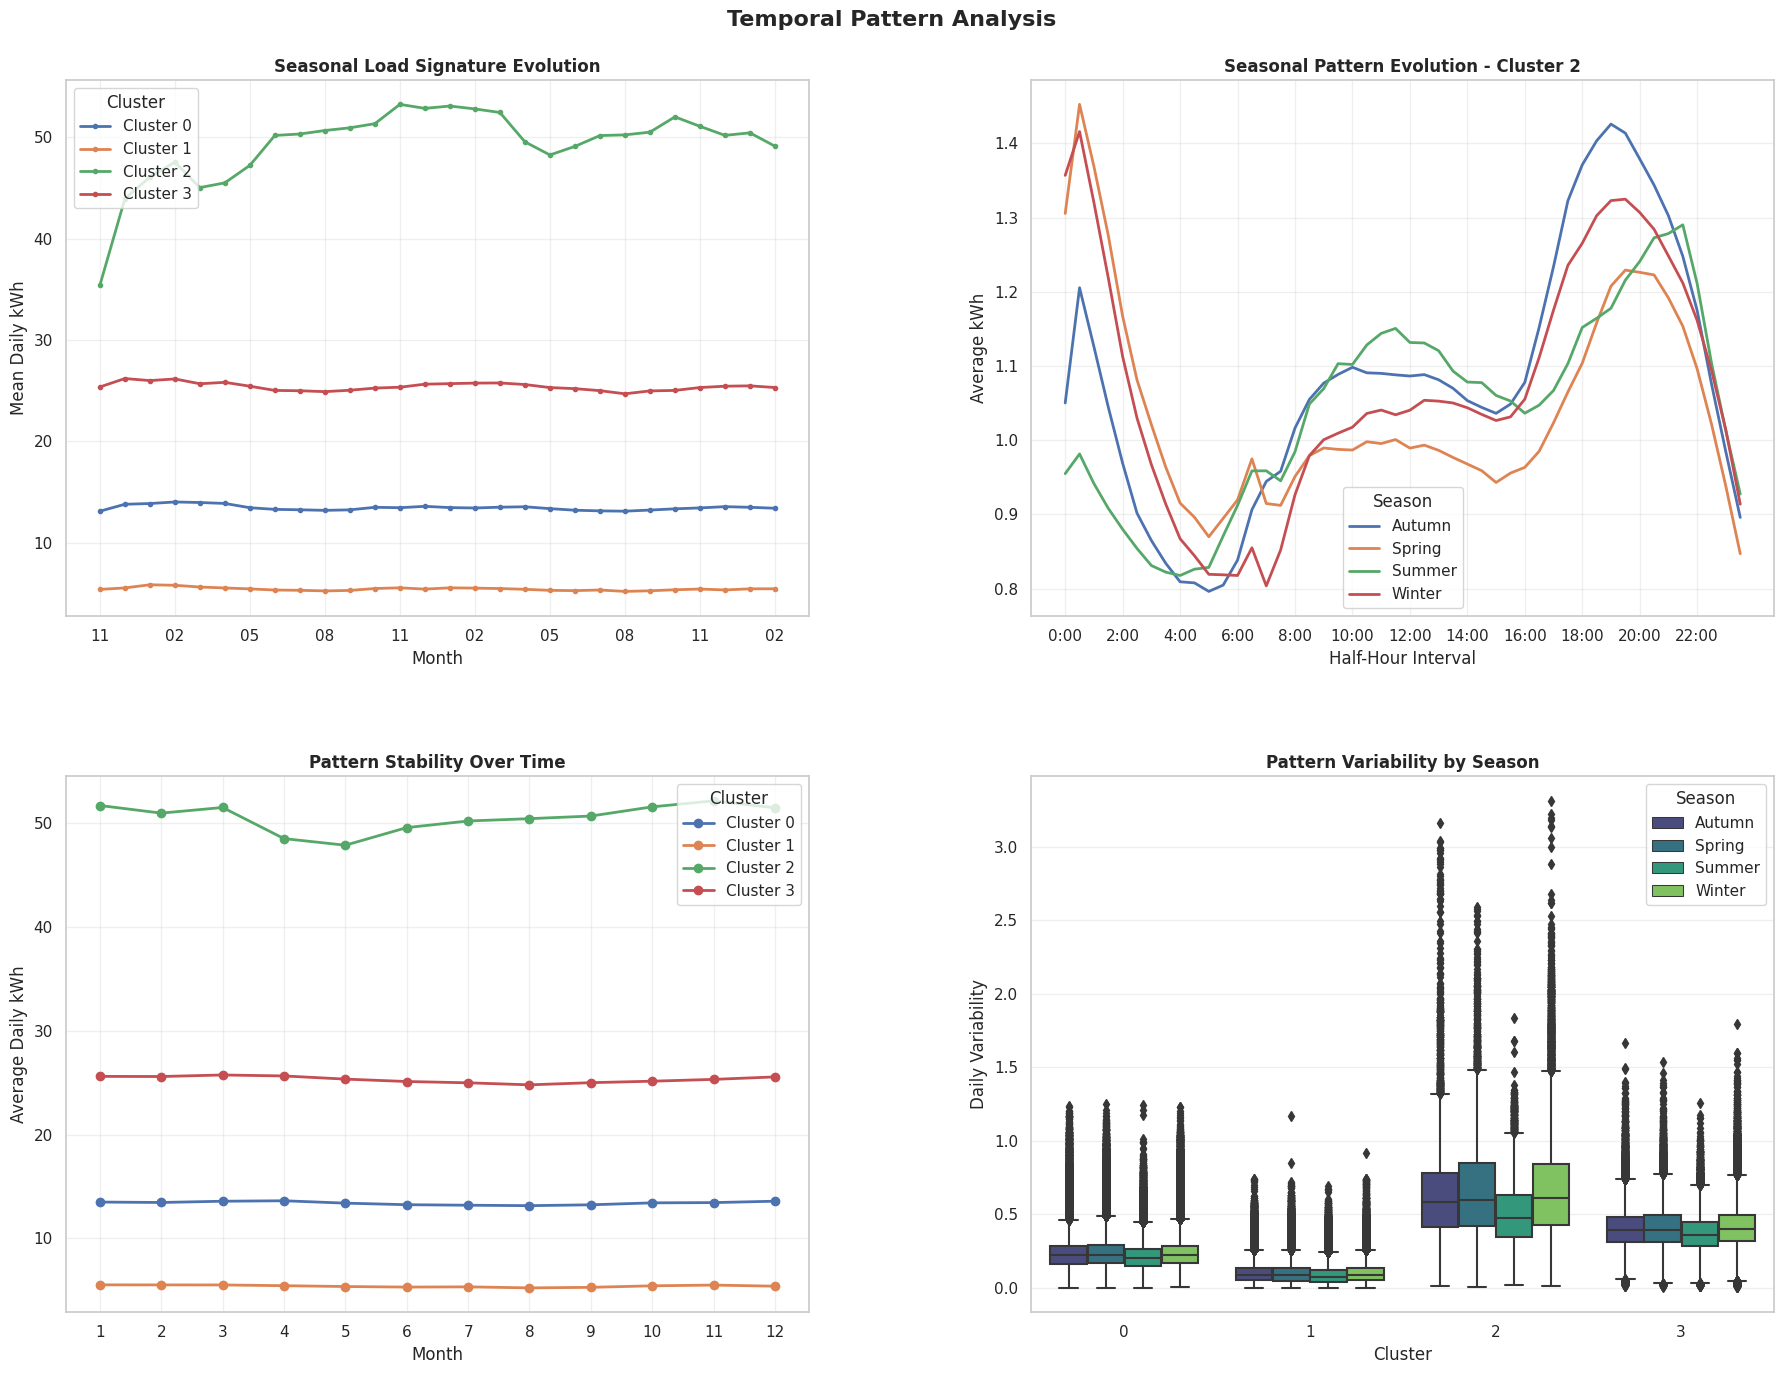

<Figure size 1400x600 with 0 Axes>

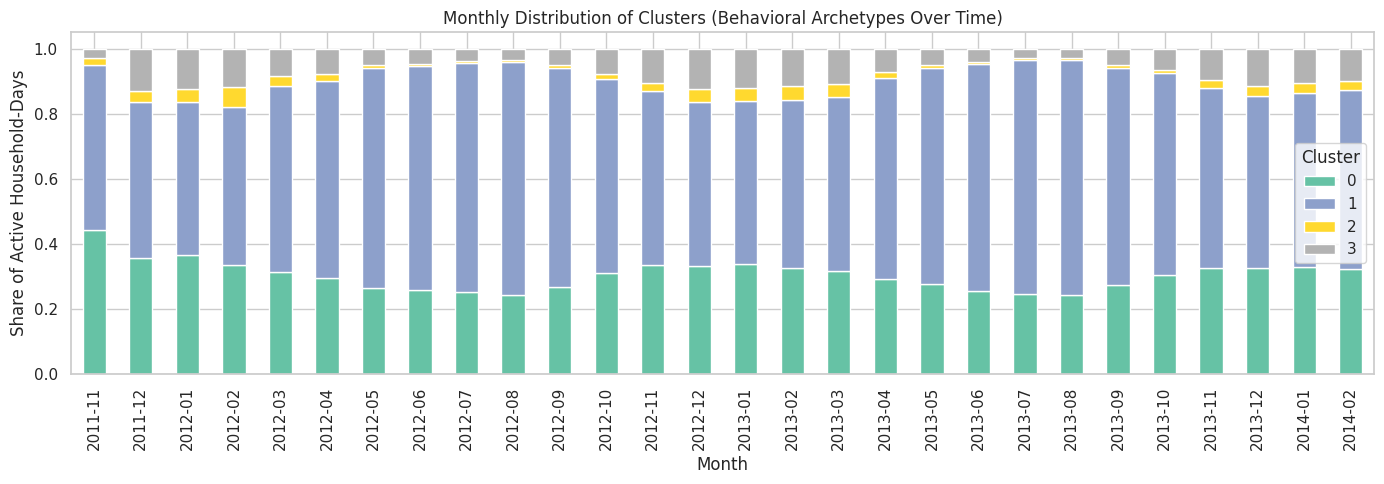

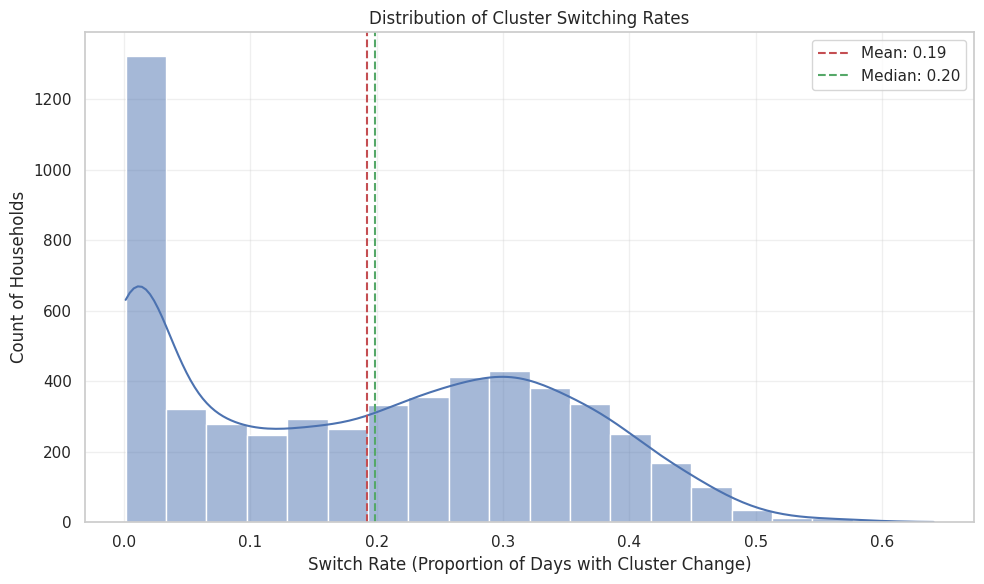

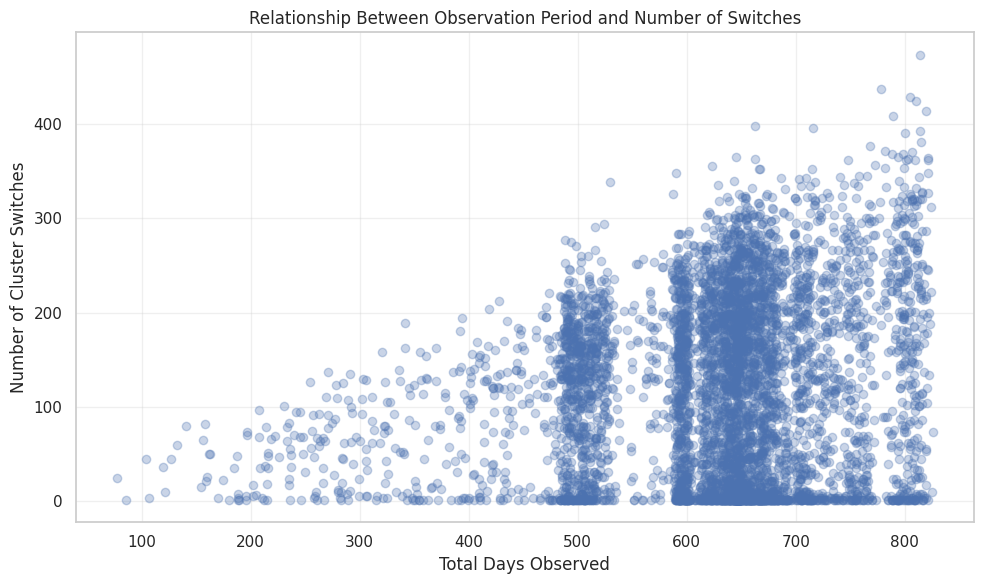

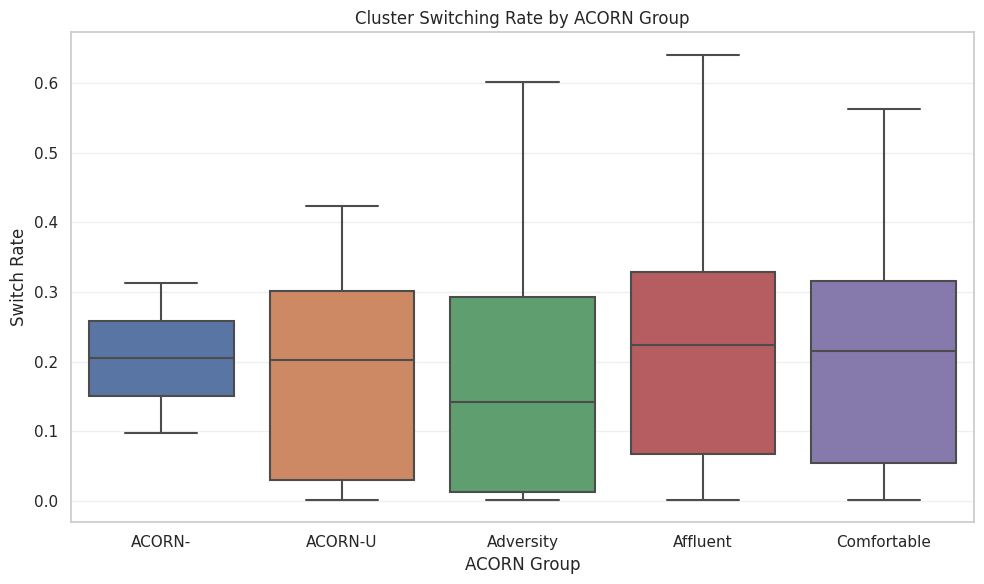

Average switch rate: 0.192
Median switch rate: 0.199
Percentage of stable households (switch rate < 0.1): 35.2%
Percentage of volatile households (switch rate > 0.5): 0.7%


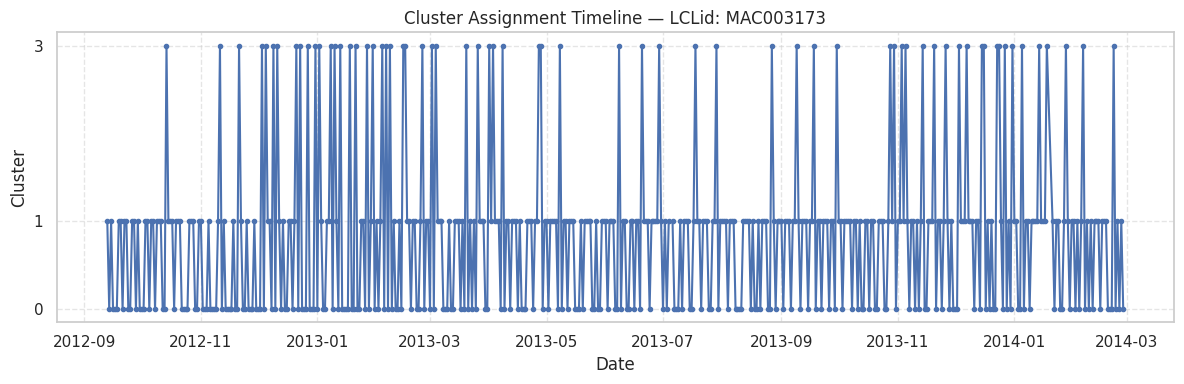

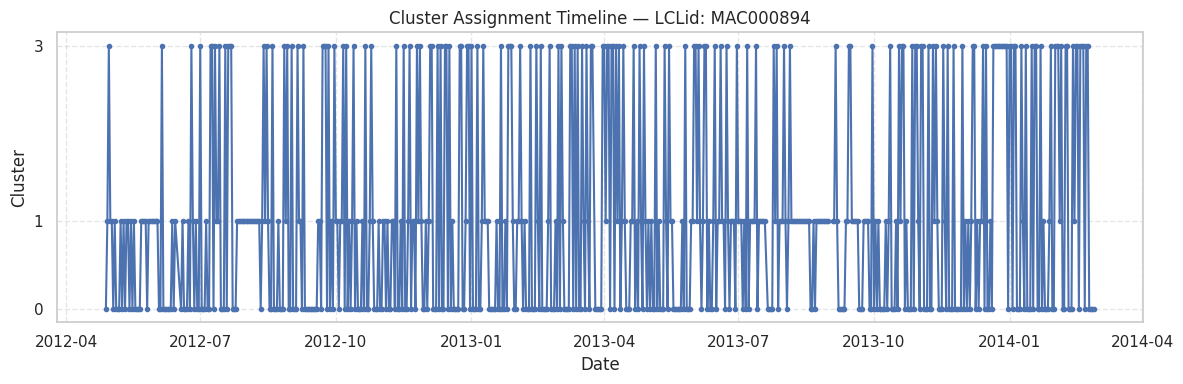

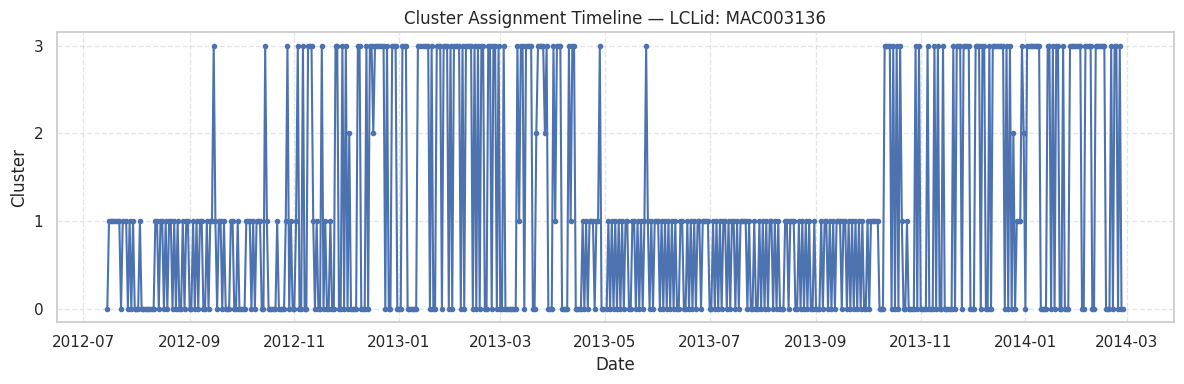

<Figure size 1400x600 with 0 Axes>

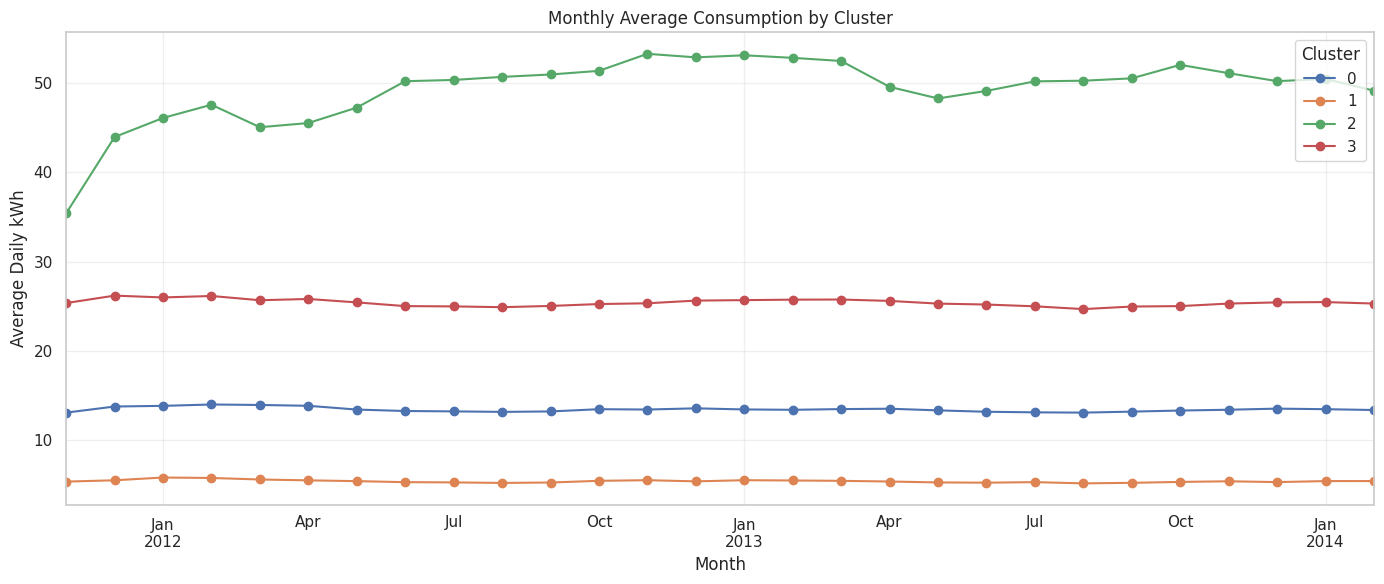

✅ Pattern Evolution Analysis Complete!


In [23]:
#Complete pattern evolution analysis
df_evol = plot_pattern_evolution_analysis(df_features, cluster_col="kmeans_cluster")

🔍 Running Cluster Stability Analysis...


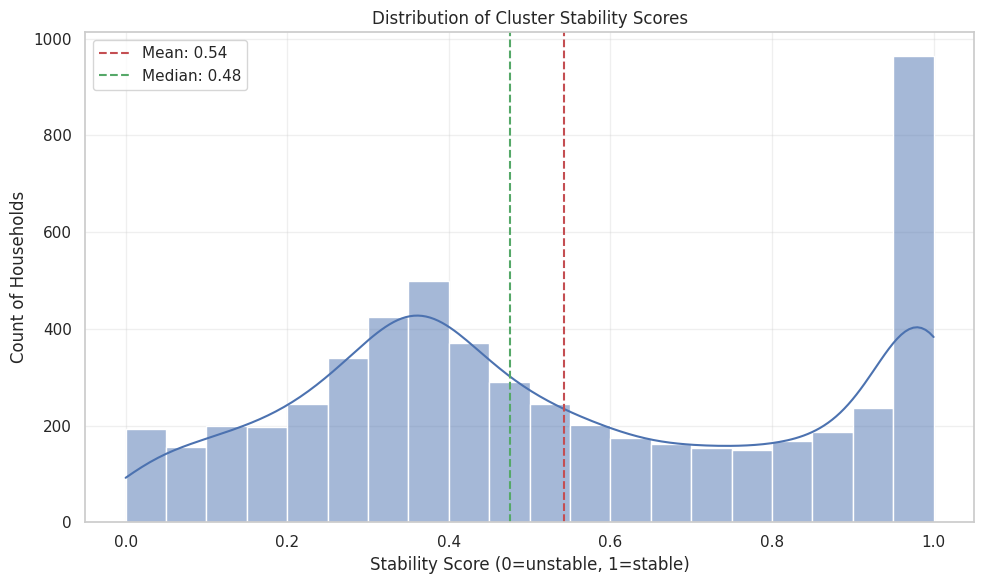

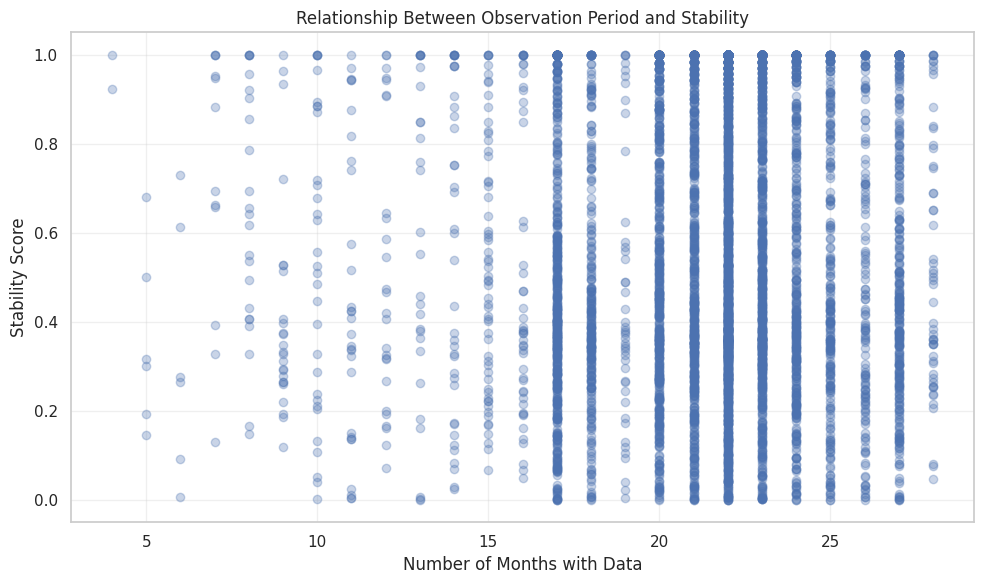

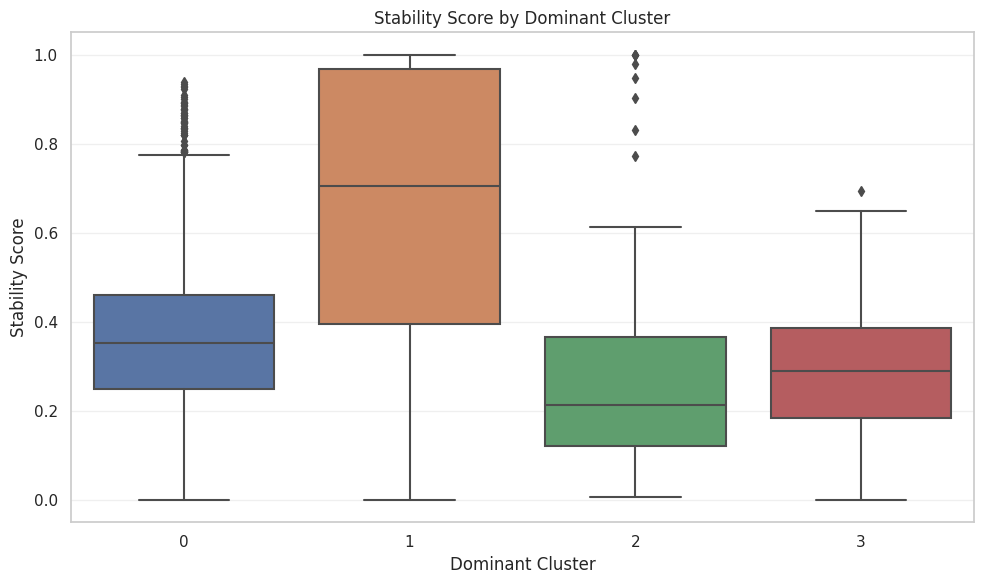

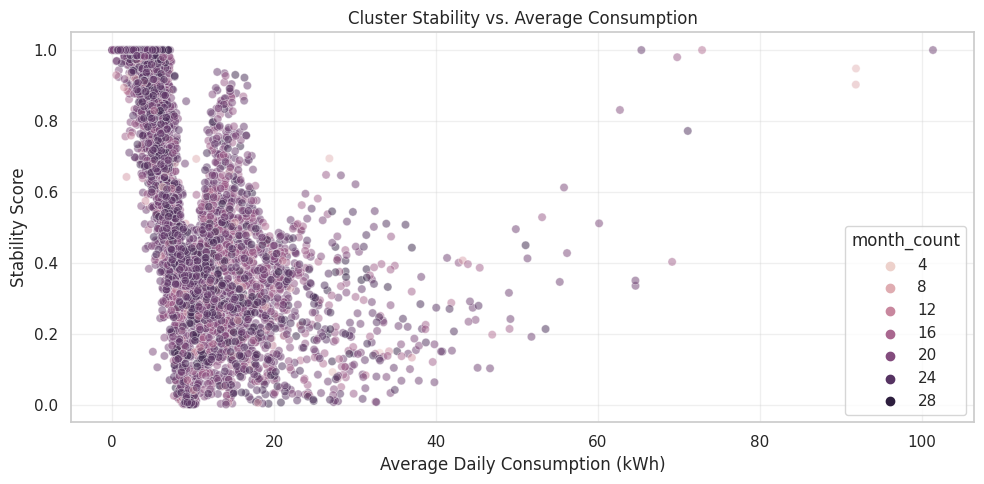


✅ Cluster Stability Analysis Complete!


LCLid  dominant_cluster  dominant_proportion   entropy  \
0     MAC000002                 0             0.650602  1.211496   
1     MAC000003                 0             0.640816  1.279408   
2     MAC000004                 1             1.000000 -0.000000   
3     MAC000005                 1             0.992076  0.072413   
4     MAC000006                 1             1.000000 -0.000000   
...         ...               ...                  ...       ...   
5551  MAC005561                 1             0.793286  0.735154   
5552  MAC005562                 0             0.574046  1.010264   
5553  MAC005564                 1             0.998249  0.018562   
5554  MAC005566                 1             0.483366  1.639363   
5555  MAC005567                 1             0.974537  0.171102   

      stability_score  month_count  
0            0.394252           17  
1            0.192783           25  
2            1.000000           22  
3            0.954313           21  
4            1.000000           26  
...               ...          ...  
5551         0.264846           19  
5552         0.362594           22  
5553         0.981438           19  
5554         0.180319           17  
5555         0.828898           15  

[5556 rows x 6 columns]

In [24]:
from visualization.clustering .stability import plot_cluster_stability_analysis

# Analyze cluster stability
plot_cluster_stability_analysis(df_features, cluster_col="kmeans_cluster")

### Cluster Switching Behavior and Lifestyle Evolution

To quantify behavioral stability, we measured how many distinct clusters each household transitioned through over the study period.

#### Key Findings:
- Around 60% of households stayed in **1–2 clusters**, indicating stable, consistent demand patterns.
- Roughly 35–40% exhibited more variability, appearing in **3 or more clusters** — driven by seasonal use, schedule changes, or occupancy shifts.
- Case studies of highly volatile users (e.g., LCLid: MAC000808) revealed frequent transitions across 3–4 behavioral archetypes, with seasonal or erratic patterns.

#### Implication:
This confirms that while many archetypes are persistent, a substantial minority show **behavioral drift** — validating the need for **adaptive modeling and real-time classification** in DSM programs and forecasts.


## 🔍 Clustering Daily Load Profiles with Autoencoder + KMeans

In this section, we uncover latent behavioral patterns in household electricity consumption by combining a deep learning–based dimensionality reduction approach with unsupervised clustering.

### 📌 Motivation
Traditional clustering methods like KMeans struggle with high-dimensional and noisy time-series data, especially when using raw Euclidean distances. To overcome this, we adopt a **nonlinear feature learning approach** using an autoencoder neural network.

### 🧠 Method Overview

- **Input**: Daily load shapes represented as 48-dimensional vectors (half-hourly `hh_0` to `hh_47`)
- **Architecture**: Deep, symmetric **autoencoder** with 3 layers; bottleneck layer encodes a compressed 4D latent representation
- **Clustering**: Apply **KMeans** to the learned latent space to identify recurring load-shape archetypes
- **Benefits**:
  - Captures complex, nonlinear usage patterns
  - Robust to noise and subtle timing shifts
  - Produces clusters that are behaviorally interpretable and temporally stable

### 🔧 Technical Setup
- Framework: TensorFlow / Keras
- Activation: ReLU (encoder/decoder), linear (output)
- Loss: Mean Squared Error (MSE)
- Optimizer: Adam
- Dimensionality: Input = 48 → Latent = 4 → Reconstructed = 48

This approach allows us to extract high-level consumption motifs and cluster households based on **how they use electricity throughout the day**, not just how much. These clusters serve as the foundation for subsequent analyses on seasonality, weather sensitivity, and demand-side intervention design.


In [25]:
# --- 1. Prepare input data ---
X = df_features[hh_cols].astype(np.float32).values
latent_dim = 10
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. Define deep autoencoder with regularization ---

inp = Input(shape=(X_scaled.shape[1],))
x = Dense(64, kernel_regularizer=l2(1e-4))(inp)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(32, kernel_regularizer=l2(1e-4))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

latent = Dense(10, activation='relu',
               activity_regularizer=l1(1e-5),
               name='latent')(x)
x = BatchNormalization()(latent)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
out = Dense(X_scaled.shape[1], activation='sigmoid')(x)

autoencoder = Model(inp, out)
encoder = Model(inp, latent)
autoencoder.compile(optimizer='adam', loss='mse')

# --- 3. Train the autoencoder ---
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_scaled, X_scaled,
                validation_split=0.2,
                epochs=50,
                batch_size=1024,
                shuffle=True,
                callbacks=[EarlyStopping('val_loss', patience=3, restore_best_weights=True)],
                verbose=0)

print("  → Training complete")
# Evaluate reconstruction on the full dev set
print("Evaluating reconstruction loss on dev set...")
recon_loss = autoencoder.evaluate(X_scaled, X_scaled, batch_size=1024, verbose=0)
print(f"  → Reconstruction MSE: {recon_loss:.6f}")

# Encode & cluster
print("Encoding the dev subset into latent space...")
start_encode = time.time()
X_encoded = encoder.predict(X_scaled, batch_size=1024)
encode_time = time.time() - start_encode
print(f"  → Encoding done in {encode_time:.2f} seconds")

k = 4
print("Clustering with MiniBatchKMeans...")
start_cluster = time.time()
mbk = MiniBatchKMeans(n_clusters=4, n_init=100, random_state=42)
labels = mbk.fit_predict(X_encoded)
cluster_time = time.time() - start_cluster
print(f"  → Clustering complete in {cluster_time:.2f} seconds")

# Evaluate
print("Computing silhouette score...")
start_sil = time.time()
sil = silhouette_score(X_encoded, labels,sample_size=100000)
sil_time = time.time() - start_sil
print(f"  → silhouette complete in {sil_time:.2f} seconds")
print(f"  → latent_dim={latent_dim} gives silhouette={sil:.4f}")

# --- New: Compute Davies–Bouldin Index (DBI) ---
print("Computing Davies–Bouldin Index...")
start_dbi = time.time()

# Use a subset if dataset is too large
sample_idx = np.random.choice(len(X_encoded), size=100_000, replace=False)
X_sample = X_encoded[sample_idx]
labels_sample = labels[sample_idx]

dbi = davies_bouldin_score(X_sample, labels_sample)
dbi_time = time.time() - start_dbi
print(f"  → DBI complete in {dbi_time:.2f} seconds")
print(f"  → latent_dim={latent_dim} gives Davies–Bouldin Index={dbi:.4f}")
# --- 7. Assign cluster labels ---
df_features["autoencoder_cluster"] = labels

I0000 00:00:1749276012.178556      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1749276020.041539     106 service.cc:148] XLA service 0x7ade4c0028c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749276020.042264     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749276020.484550     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749276022.600922     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  → Training complete
Evaluating reconstruction loss on dev set...
  → Reconstruction MSE: 0.000670
Encoding the dev subset into latent space...
3389/3389 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
  → Encoding done in 8.31 seconds
Clustering with MiniBatchKMeans...
  → Clustering complete in 0.36 seconds
Computing silhouette score...
  → silhouette complete in 101.08 seconds
  → latent_dim=10 gives silhouette=0.6747
Computing Davies–Bouldin Index...
  → DBI complete in 0.13 seconds
  → latent_dim=10 gives Davies–Bouldin Index=0.5139


🔧 Preparing features for plotting...
✅ Created 'temp_impact' as temperature-consumption correlation
🎯 Feature preparation complete! DataFrame shape: (3469317, 138)


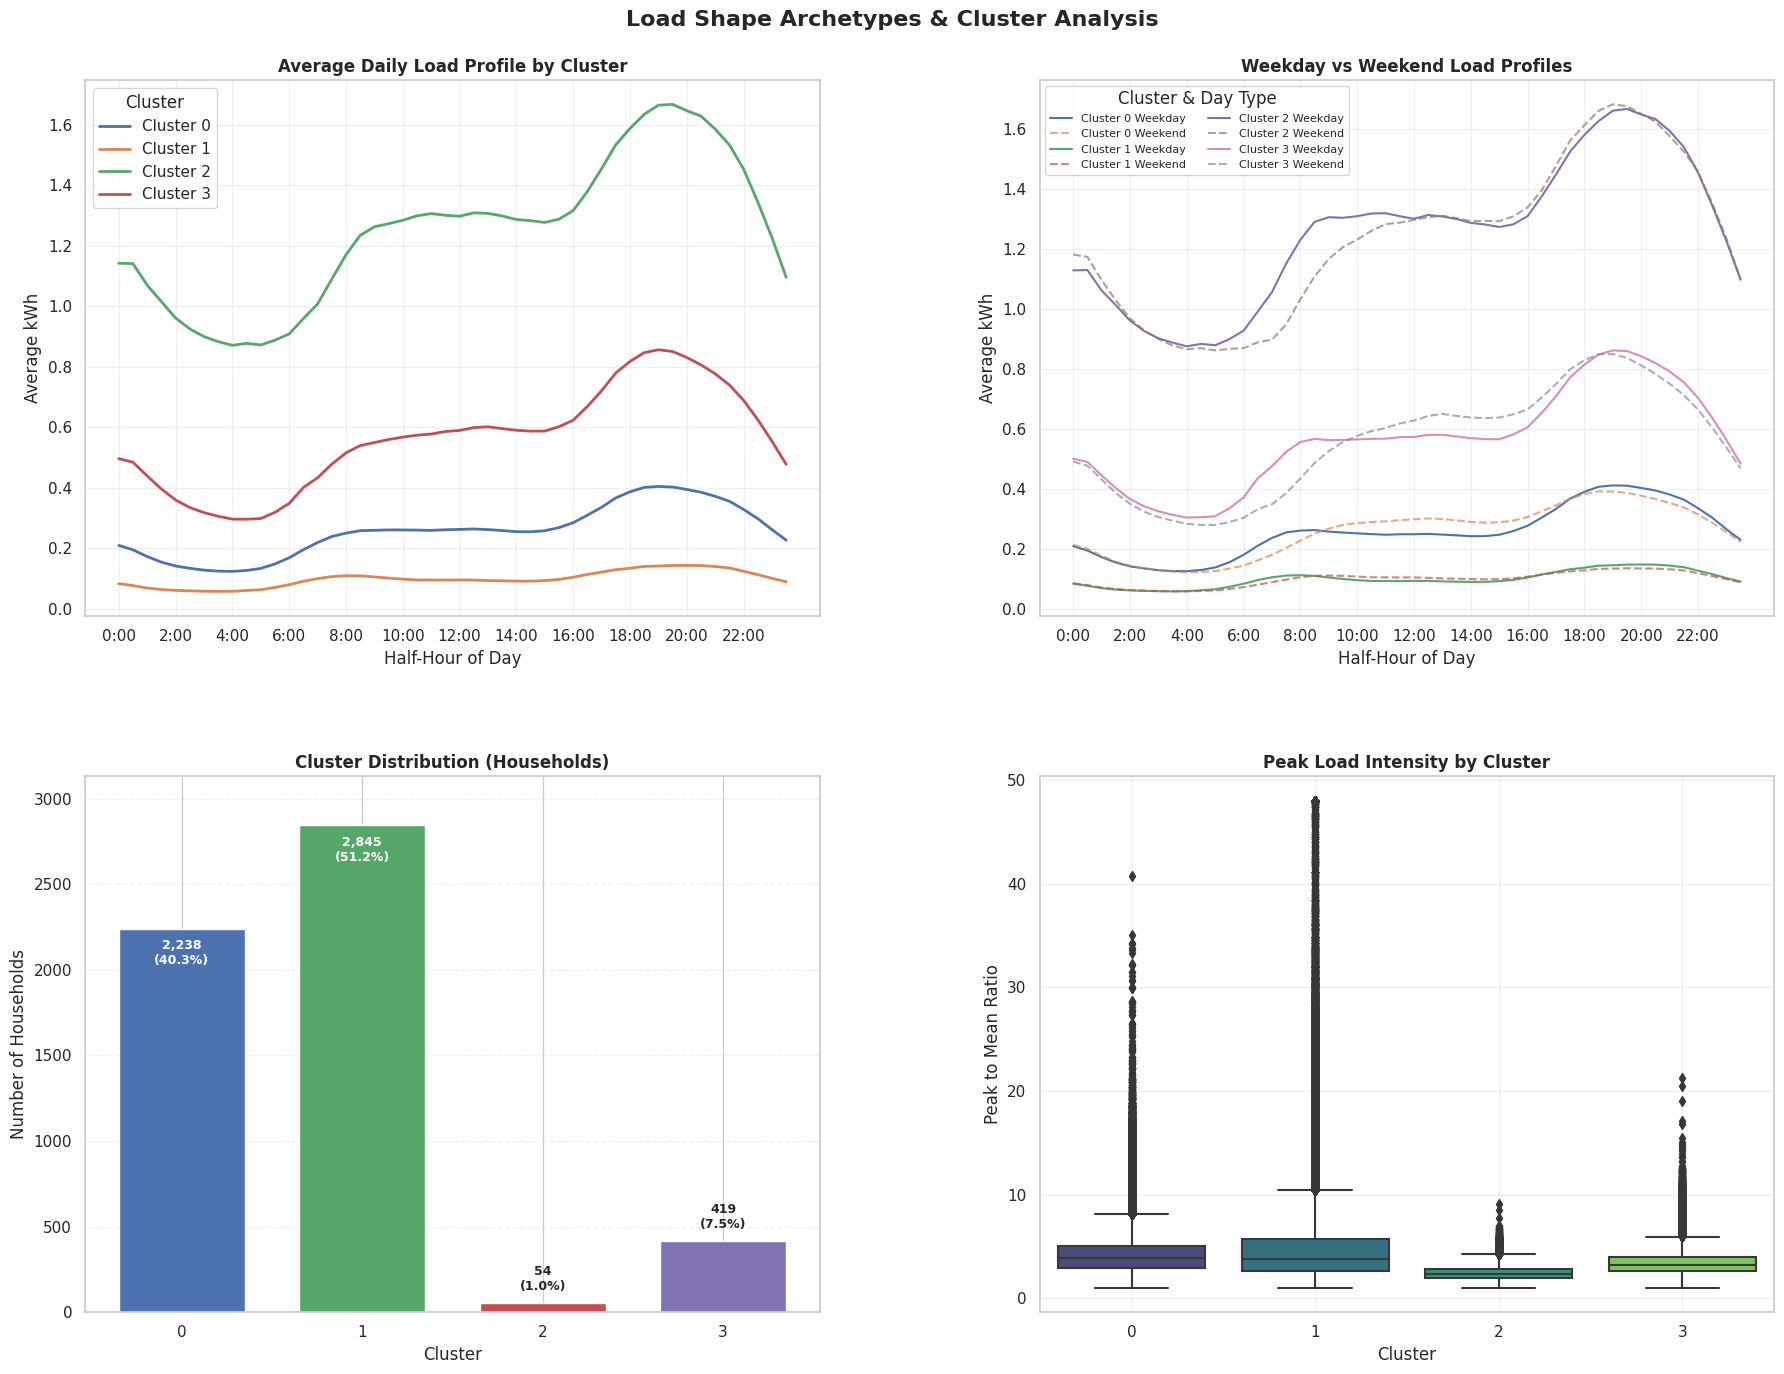

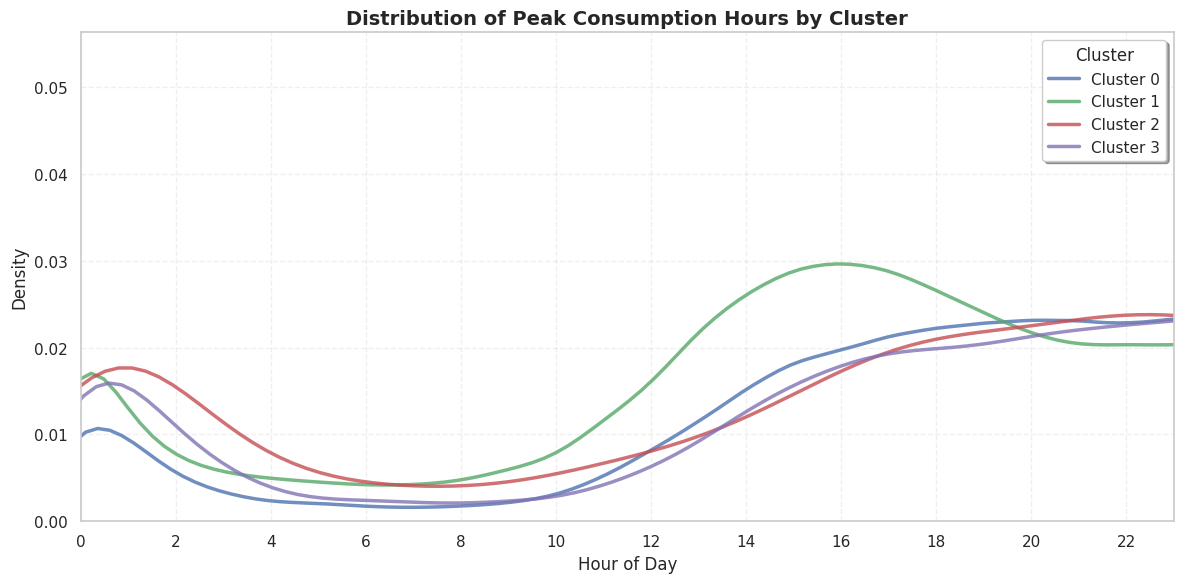

✅ Load Shape Analysis Complete!


{0: array([0.2099148 , 0.19543114, 0.17317787, 0.15481864, 0.14176032,
        0.13433501, 0.1282801 , 0.12496796, 0.12412175, 0.1271378 ,
        0.13396695, 0.1486437 , 0.1691675 , 0.19571157, 0.2193472 ,
        0.23933253, 0.25059322, 0.25862953, 0.2598942 , 0.2611736 ,
        0.2611099 , 0.26050243, 0.25957575, 0.2617855 , 0.2628438 ,
        0.2643558 , 0.26227418, 0.25907883, 0.2554509 , 0.25504556,
        0.25848323, 0.26891616, 0.284909  , 0.3099277 , 0.33603394,
        0.36701947, 0.38711834, 0.4018738 , 0.40484485, 0.40291962,
        0.39484677, 0.3858537 , 0.37231997, 0.35601252, 0.32890296,
        0.2985301 , 0.26213762, 0.22724079], dtype=float32),
 1: array([0.08361392, 0.07709622, 0.06914745, 0.06414504, 0.06135594,
        0.05967107, 0.05852713, 0.05789713, 0.05835165, 0.06082305,
        0.06369407, 0.07115261, 0.08011079, 0.09132336, 0.1002712 ,
        0.10674222, 0.109894  , 0.1094592 , 0.10572813, 0.10202807,
        0.09834905, 0.09575129, 0.09569207, 0.095

In [26]:
plot_load_shape_analysis(df_features, cluster_col="autoencoder_cluster")

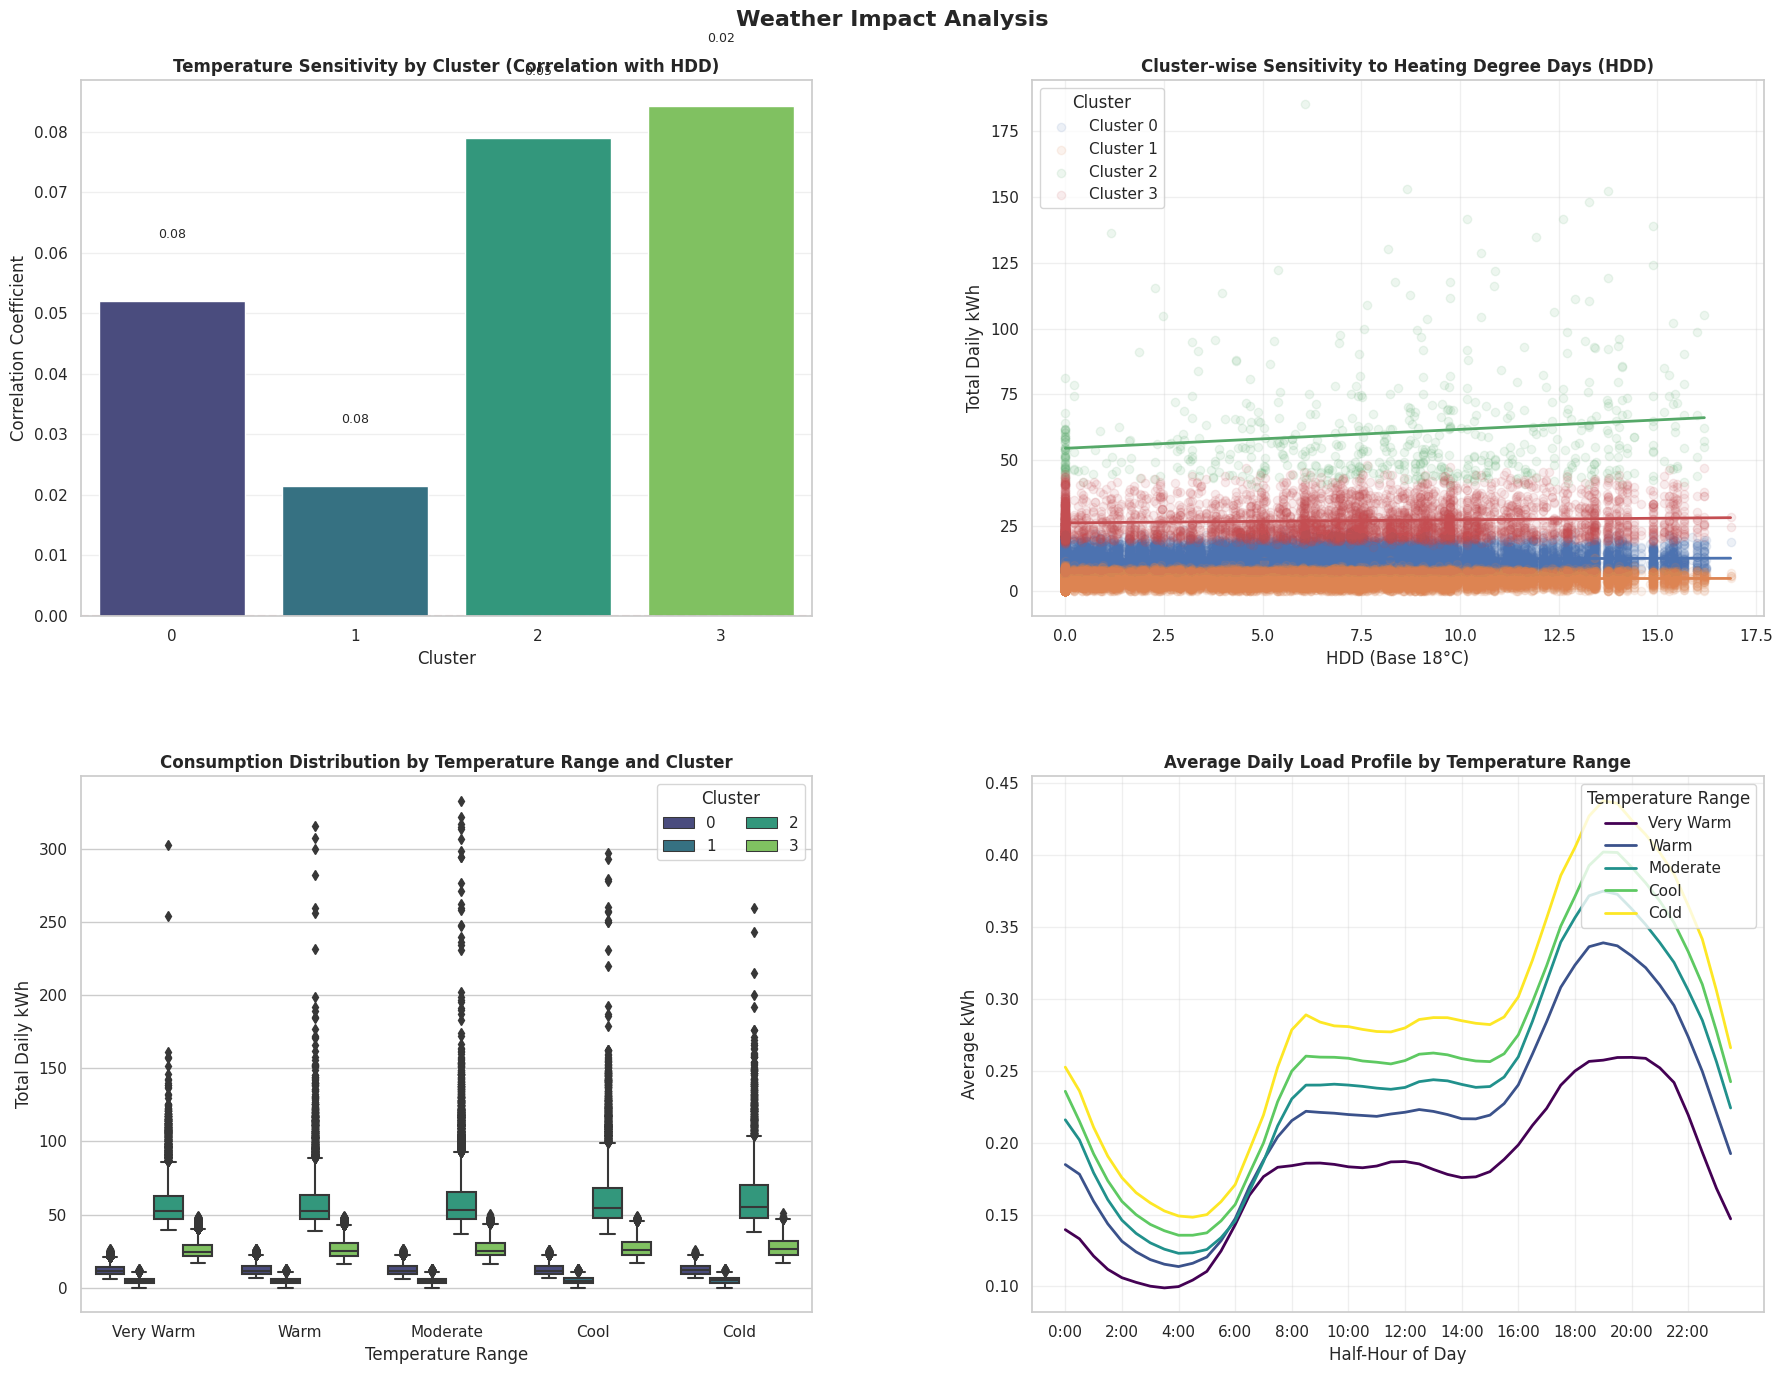

✅ Weather Impact Analysis Complete!


In [27]:
plot_weather_impact_analysis(df_features, cluster_col="autoencoder_cluster") 

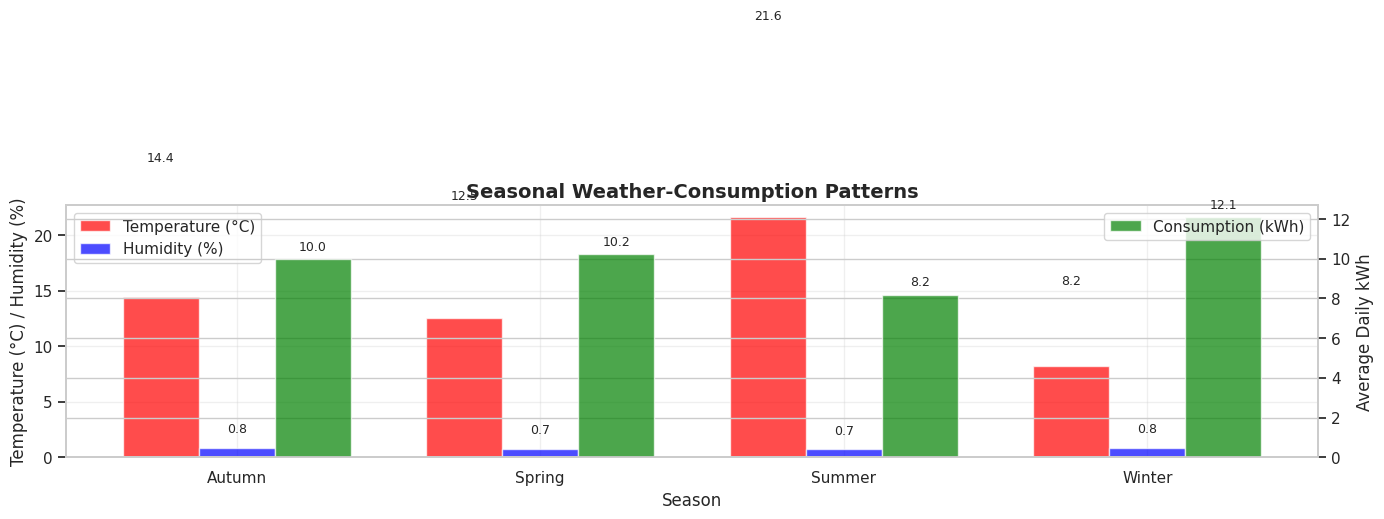

✅ Seasonal Weather Patterns Analysis Complete!


<Figure size 1400x800 with 0 Axes>

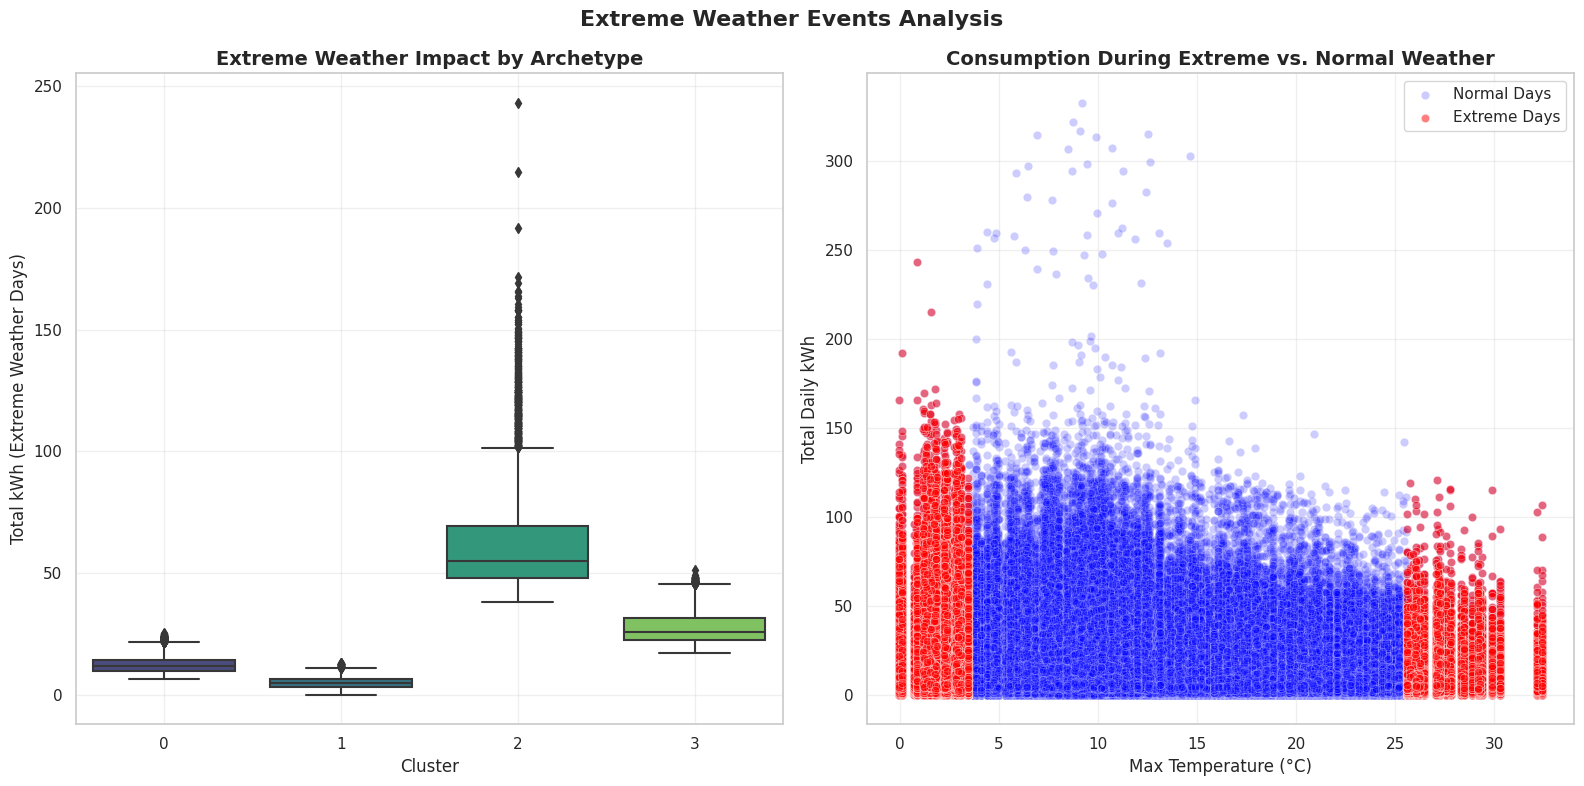

✅ Extreme Weather Impact Analysis Complete!


In [28]:
plot_seasonal_weather_patterns(df_features, cluster_col="autoencoder_cluster") 
plot_extreme_weather_impact(df_features, cluster_col="autoencoder_cluster") 

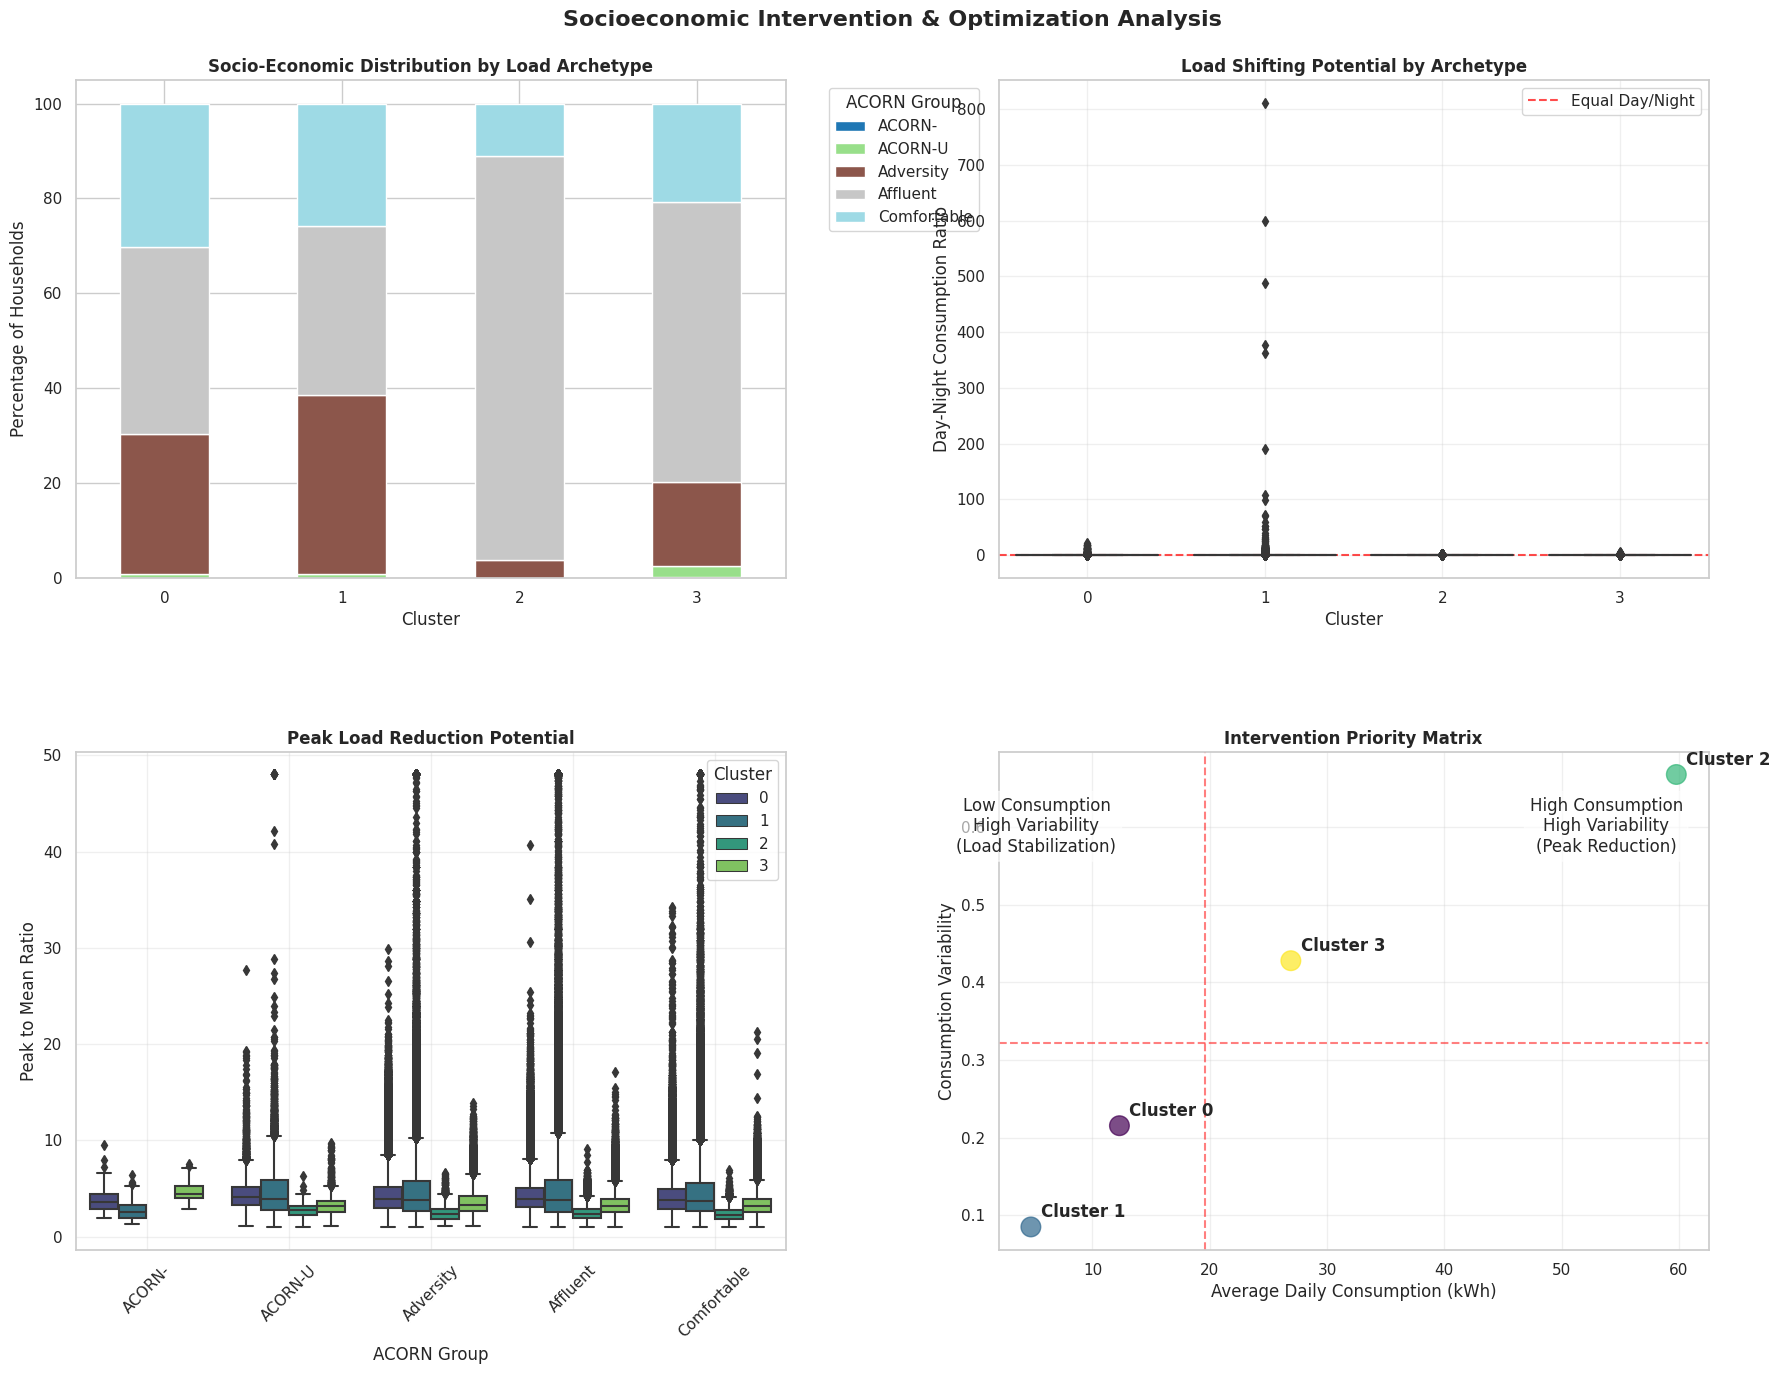

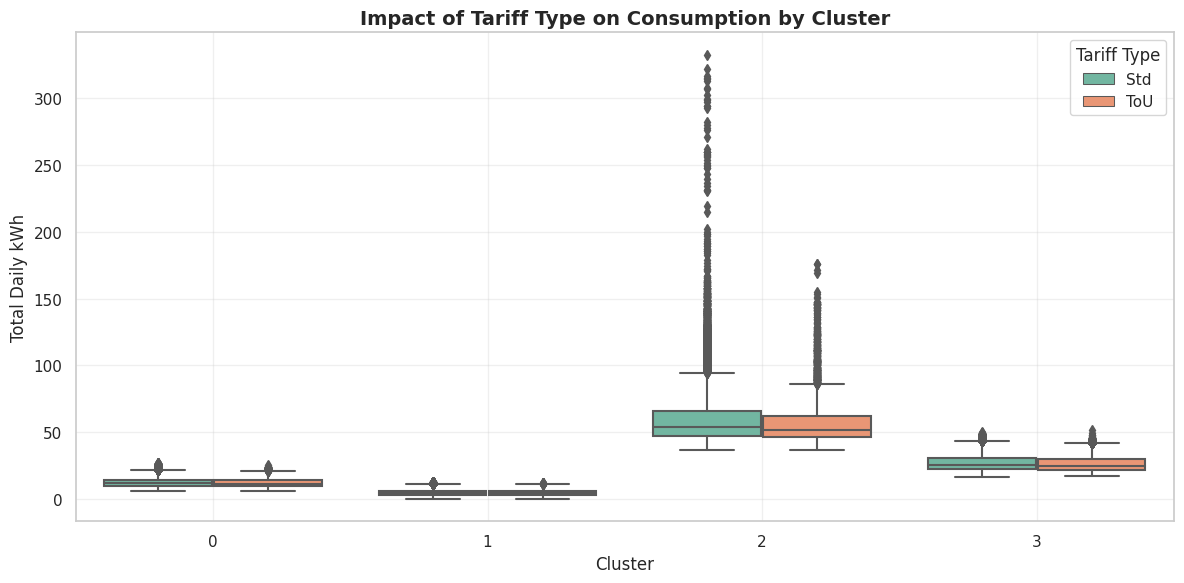

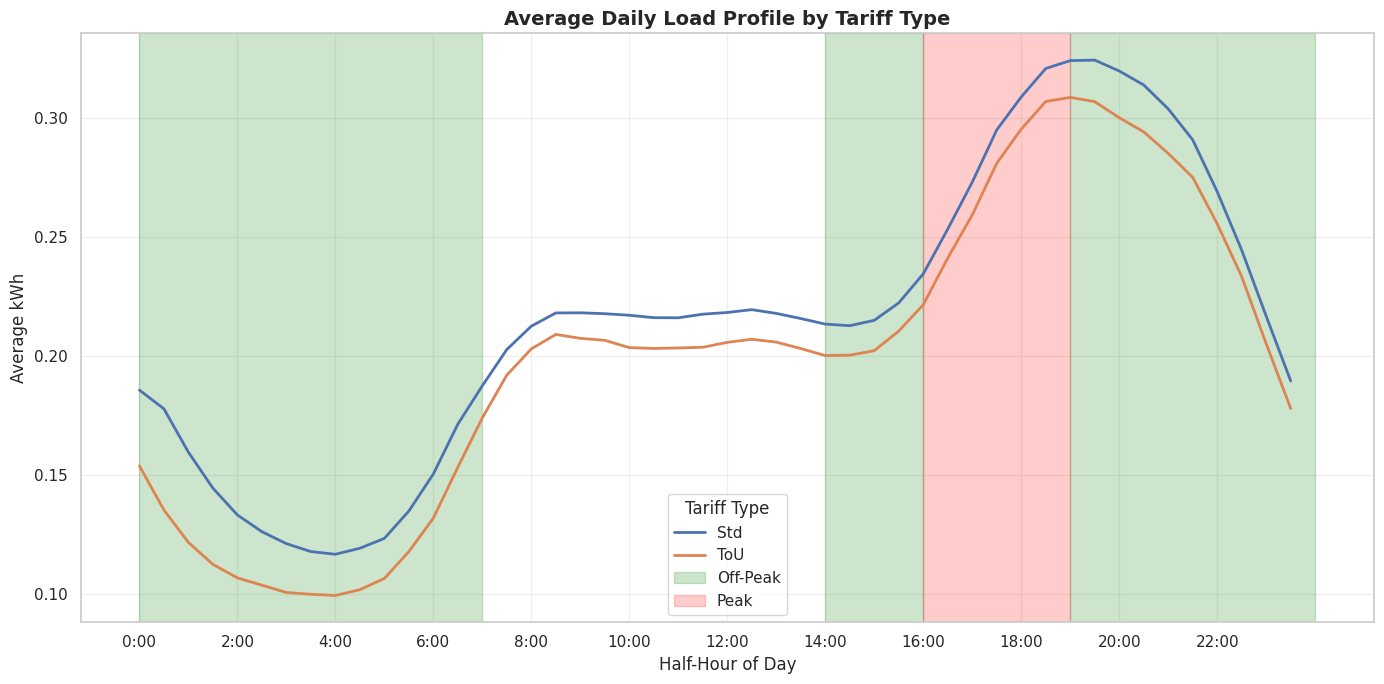

✅ Socioeconomic Intervention Analysis Complete!


LCLid  autoencoder_cluster Acorn_grouped
95696    MAC000002                    0      Affluent
2797754  MAC000003                    3     Adversity
3175096  MAC000004                    1      Affluent
2768487  MAC000005                    1      Affluent
1442819  MAC000006                    1     Adversity
...            ...                  ...           ...
2214710  MAC005561                    1     Adversity
845769   MAC005562                    0   Comfortable
3143116  MAC005564                    1     Adversity
3374289  MAC005566                    2      Affluent
1252440  MAC005567                    1     Adversity

[5556 rows x 3 columns]

In [29]:
plot_socioeconomic_intervention_analysis(df_features, cluster_col="autoencoder_cluster")

🔧 Preparing features for plotting...
✅ Created 'temp_impact' as temperature-consumption correlation
🎯 Feature preparation complete! DataFrame shape: (3469317, 138)

Cluster Profile Summary:

                     total_kwh        peak_hour                    stdorToU  \
                          mean    std      mean most_frequent most_frequent   
autoencoder_cluster                                                           
0                    12.300000   3.25     30.15          37.0           Std   
1                     4.750000   2.01     27.78          37.0           Std   
2                    59.779999  19.68     28.30          38.0           Std   
3                    26.910000   6.04     29.58          38.0           Std   

                    Acorn_grouped daily_variability  
                    most_frequent              mean  
autoencoder_cluster                                  
0                        Affluent              0.22  
1                        Affluent      

<Figure size 1200x600 with 0 Axes>

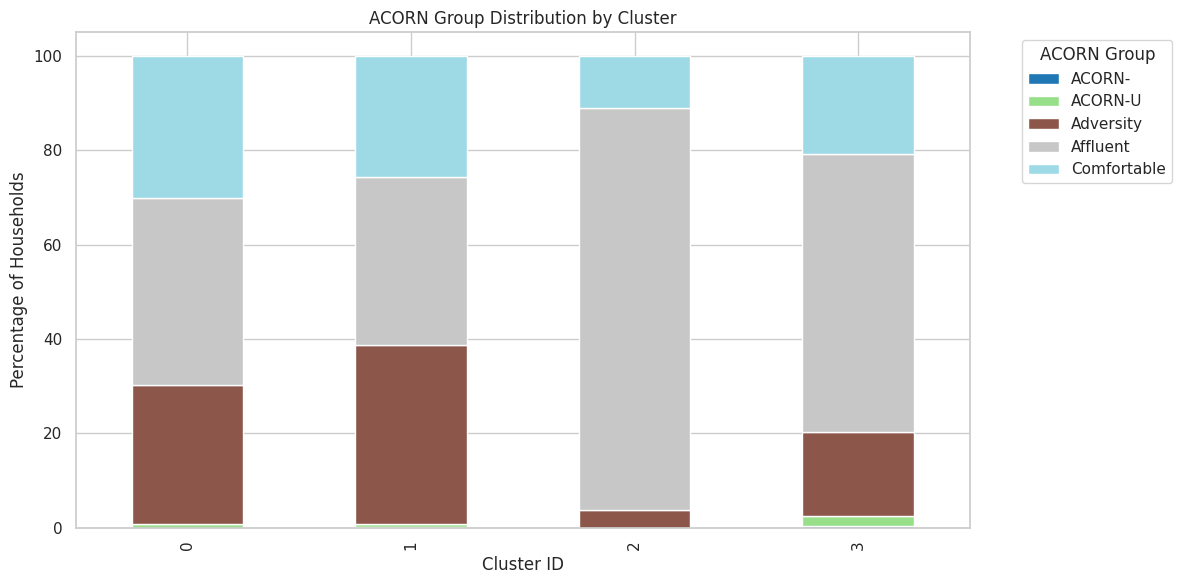

Acorn_grouped          ACORN-   ACORN-U  Adversity   Affluent  Comfortable
autoencoder_cluster                                                       
0                    0.000000  0.759607  29.535299  39.499553    30.205541
1                    0.035149  0.808436  37.785589  35.606327    25.764499
2                    0.000000  0.000000   3.703704  85.185185    11.111111
3                    0.238663  2.147971  17.899761  58.949881    20.763723

In [30]:
# Get cluster profiles
profile_data = cluster_profile_summary(df_features, cluster_col="autoencoder_cluster")

# Plot ACORN group distribution
plot_acorn_distribution(df_features, cluster_col="autoencoder_cluster")

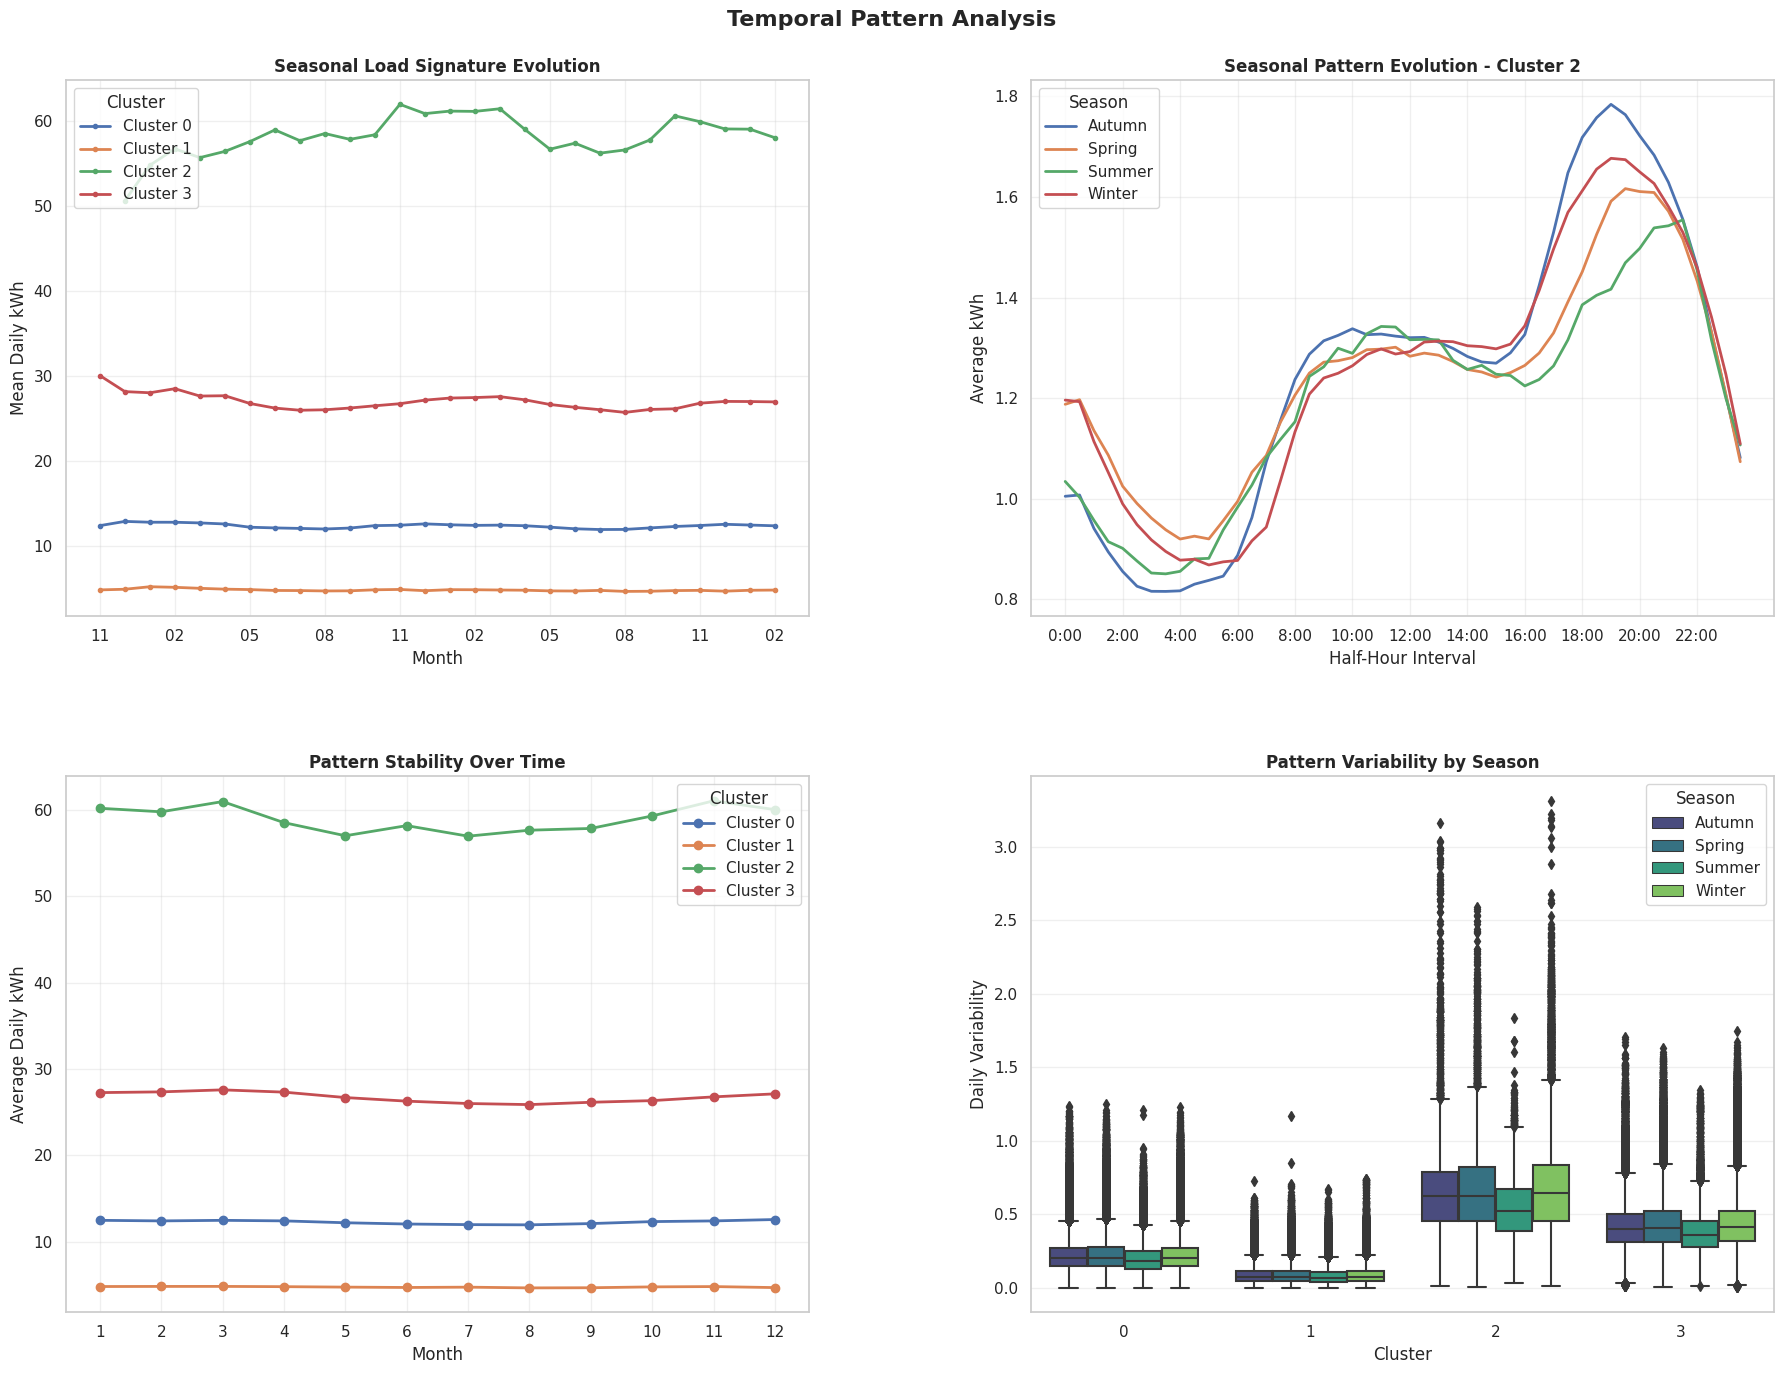

<Figure size 1400x600 with 0 Axes>

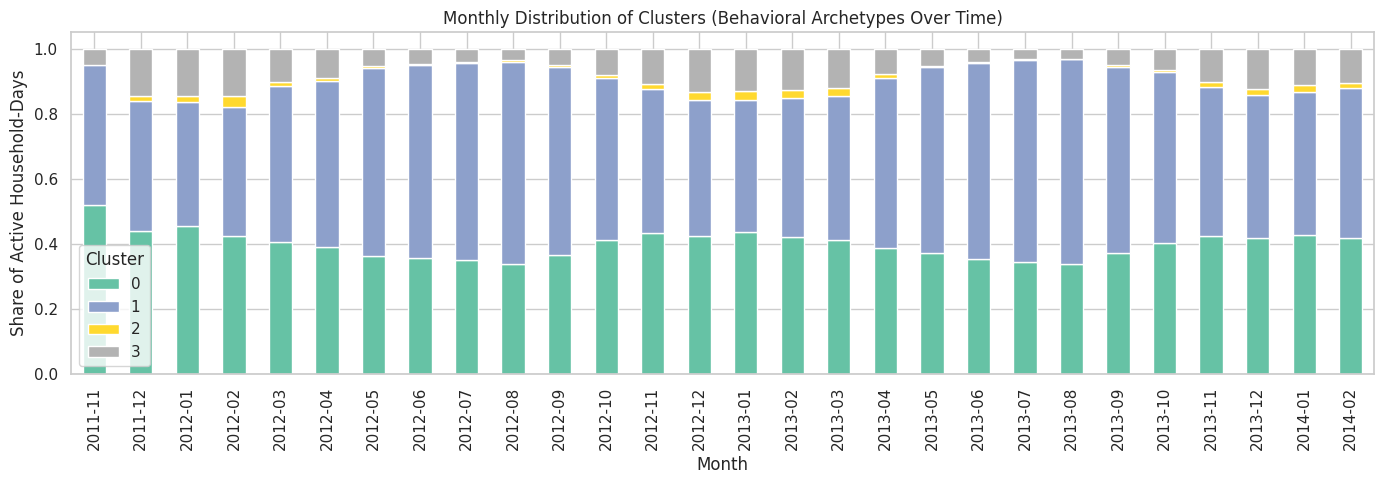

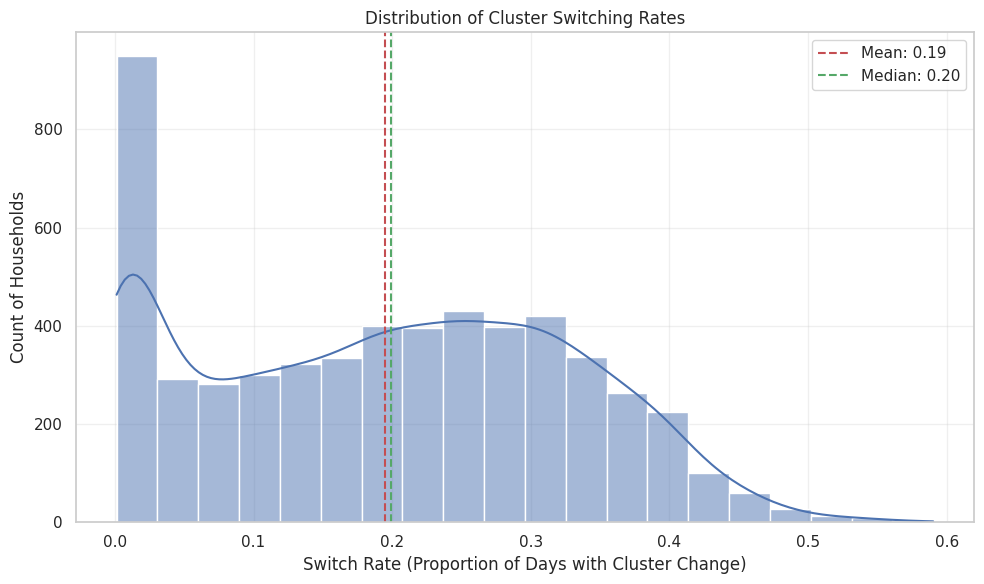

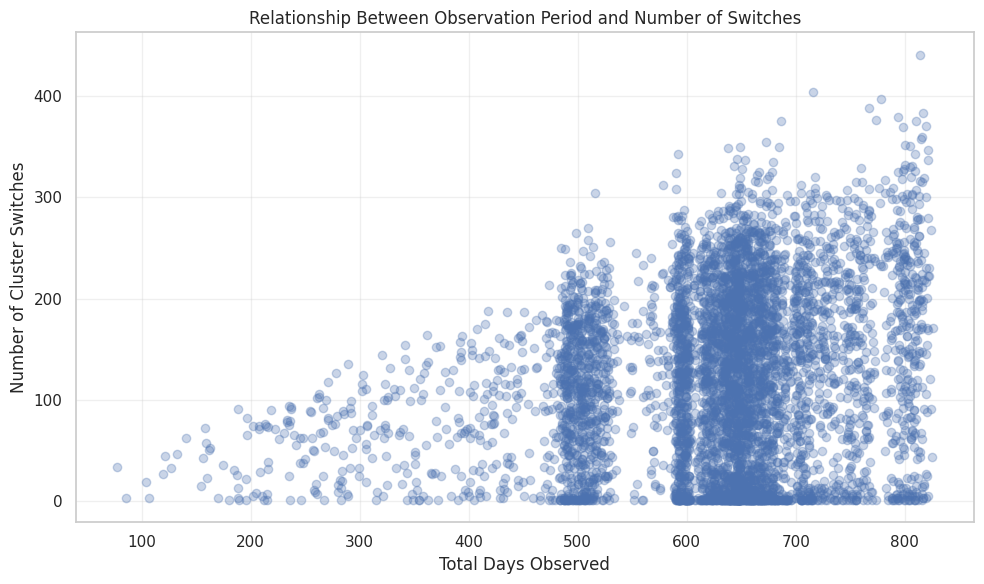

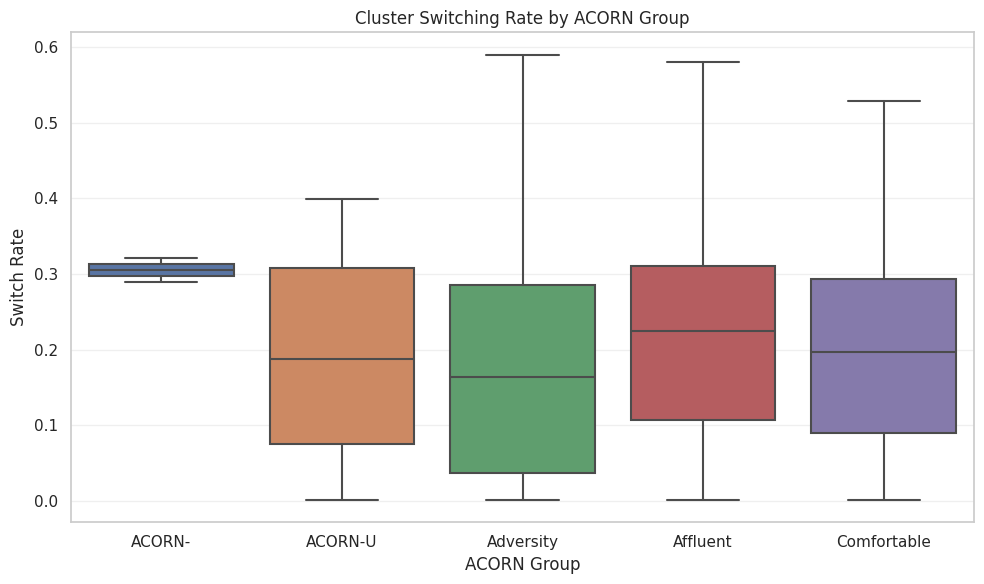

Average switch rate: 0.195
Median switch rate: 0.199
Percentage of stable households (switch rate < 0.1): 29.4%
Percentage of volatile households (switch rate > 0.5): 0.4%


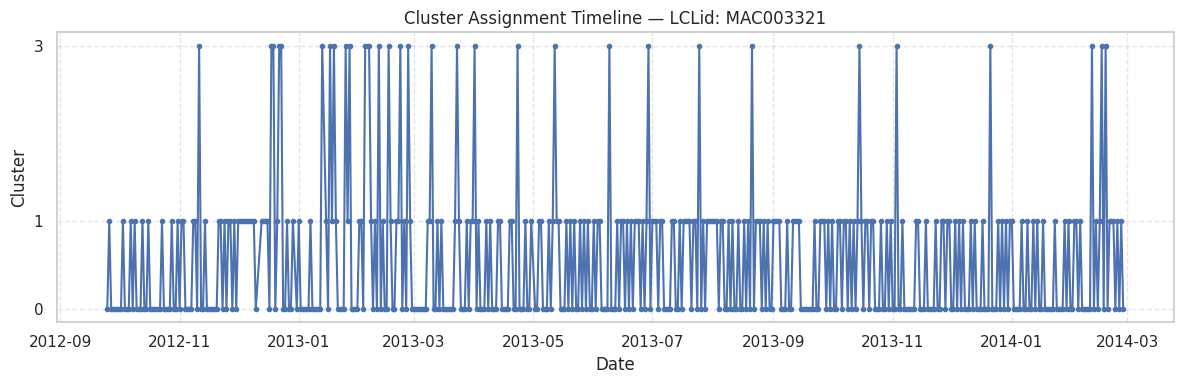

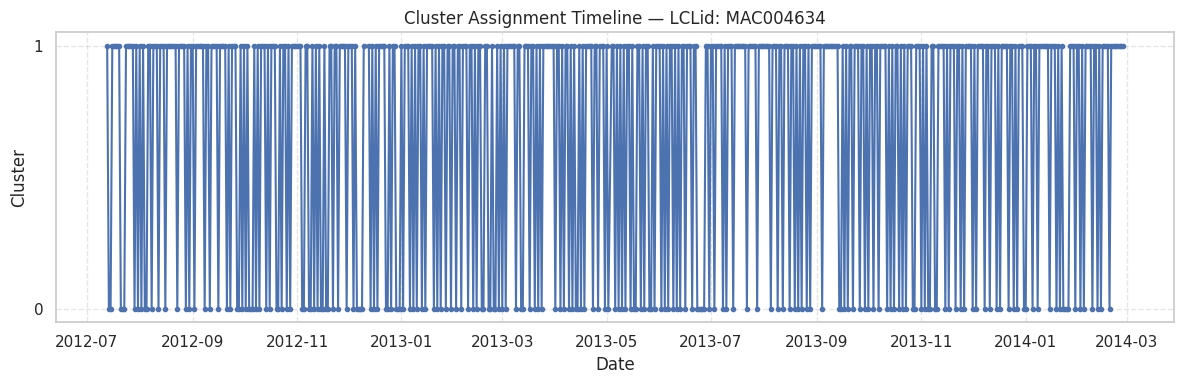

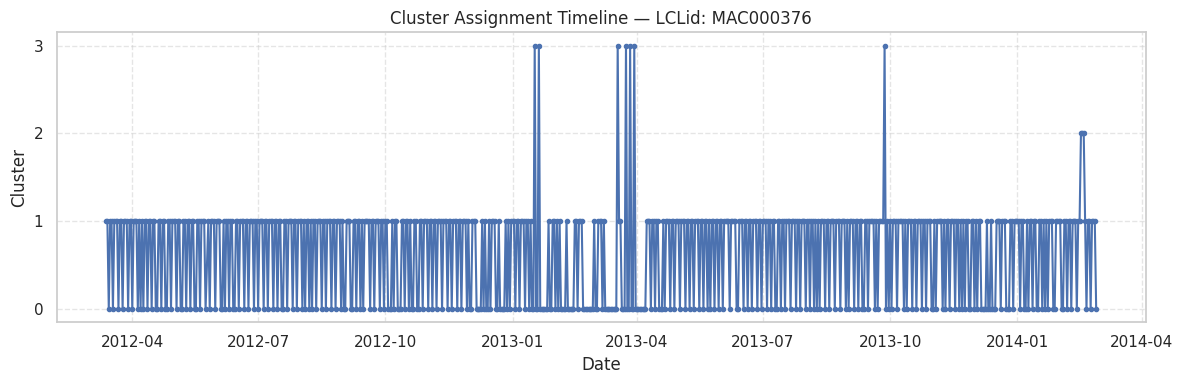

<Figure size 1400x600 with 0 Axes>

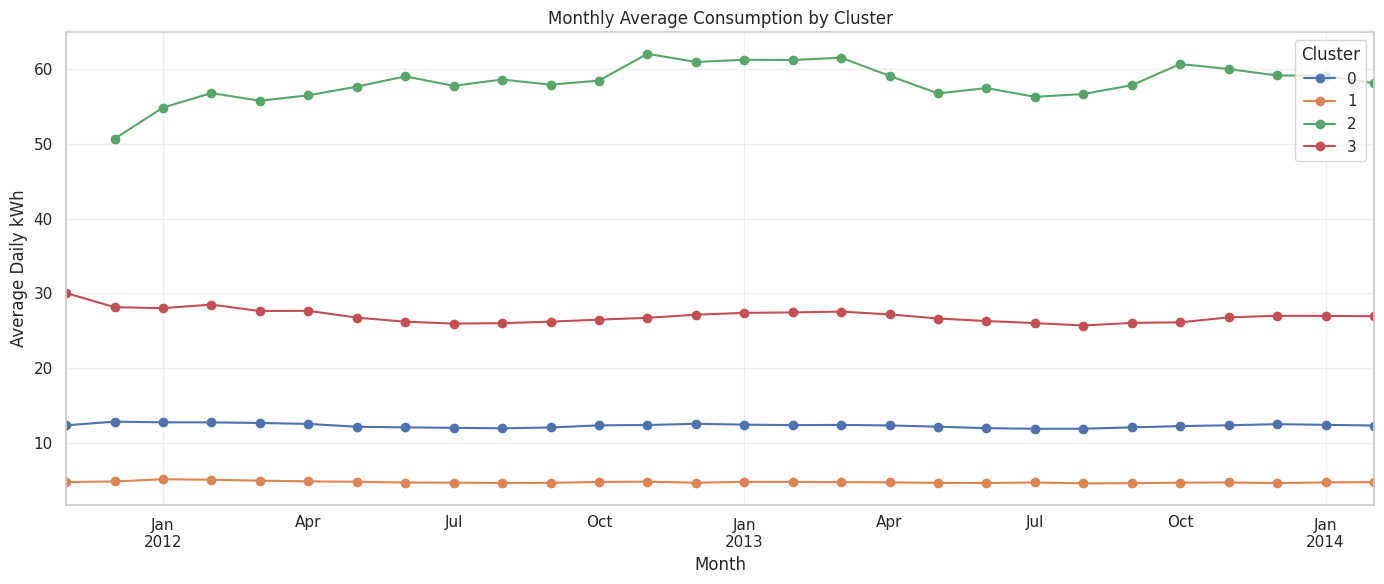

✅ Pattern Evolution Analysis Complete!


LCLid        day   hh_0   hh_1   hh_2   hh_3   hh_4   hh_5  \
95696    MAC000002 2012-10-13  0.263  0.269  0.275  0.256  0.211  0.136   
95697    MAC000002 2012-10-14  0.262  0.166  0.226  0.088  0.126  0.082   
95698    MAC000002 2012-10-15  0.192  0.097  0.141  0.083  0.132  0.070   
95699    MAC000002 2012-10-16  0.237  0.237  0.193  0.118  0.098  0.107   
95700    MAC000002 2012-10-17  0.157  0.211  0.155  0.169  0.101  0.117   
...            ...        ...    ...    ...    ...    ...    ...    ...   
1252867  MAC005567 2014-02-23  0.110  0.064  0.059  0.048  0.046  0.027   
1252868  MAC005567 2014-02-24  0.177  0.116  0.053  0.029  0.046  0.050   
1252869  MAC005567 2014-02-25  0.169  0.085  0.052  0.043  0.039  0.039   
1252870  MAC005567 2014-02-26  0.184  0.143  0.066  0.049  0.049  0.037   
1252871  MAC005567 2014-02-27  0.052  0.052  0.041  0.039  0.043  0.052   

          hh_6   hh_7  ...  delta1_total  pct_change1_total  \
95696    0.161  0.119  ...         0.000           0.000000   
95697    0.123  0.083  ...         0.000           0.000000   
95698    0.130  0.074  ...         2.136           0.192658   
95699    0.094  0.109  ...        -2.966          -0.224306   
95700    0.084  0.118  ...        -0.488          -0.047577   
...        ...    ...  ...           ...                ...   
1252867  0.046  0.050  ...         0.089           0.024860   
1252868  0.049  0.038  ...         0.273           0.074407   
1252869  0.041  0.049  ...         0.165           0.041857   
1252870  0.030  0.046  ...         1.655           0.402970   
1252871  0.047  0.044  ...        -0.696          -0.120791   

         lag1_weekend_heating  lag1_holiday_consumption  lag1_summer_cooling  \
95696                0.000000                       0.0                  0.0   
95697                6.440000                       0.0                  0.0   
95698                0.000000                       0.0                  0.0   
95699                0.000000                       0.0                  0.0   
95700                0.000000                       0.0                  0.0   
...                       ...                       ...                  ...   
1252867              4.694999                       0.0                  0.0   
1252868              0.000000                       0.0                  0.0   
1252869              0.000000                       0.0                  0.0   
1252870              0.000000                       0.0                  0.0   
1252871              0.000000                       0.0                  0.0   

         kmeans_cluster  month_name  year  yearmonth  autoencoder_cluster  
95696                 0         Oct  2012    2012-10                    0  
95697                 0         Oct  2012    2012-10                    0  
95698                 0         Oct  2012    2012-10                    0  
95699                 0         Oct  2012    2012-10                    0  
95700                 0         Oct  2012    2012-10                    0  
...                 ...         ...   ...        ...                  ...  
1252867               1         Feb  2014    2014-02                    1  
1252868               1         Feb  2014    2014-02                    1  
1252869               1         Feb  2014    2014-02                    1  
1252870               1         Feb  2014    2014-02                    1  
1252871               1         Feb  2014    2014-02                    1  

[3469317 rows x 137 columns]

In [31]:
plot_pattern_evolution_analysis(df_features, cluster_col="autoencoder_cluster")

🔍 Running Cluster Stability Analysis...


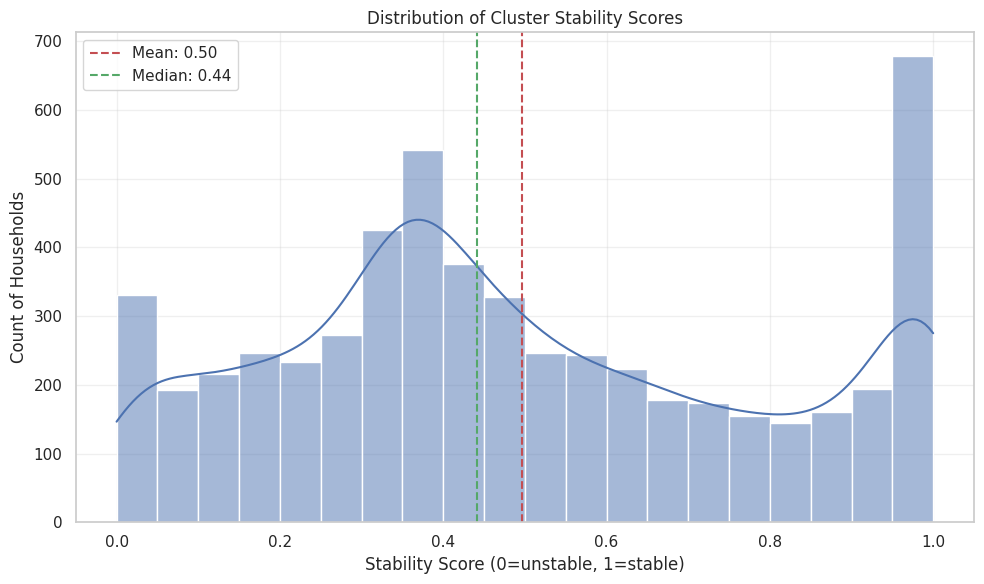

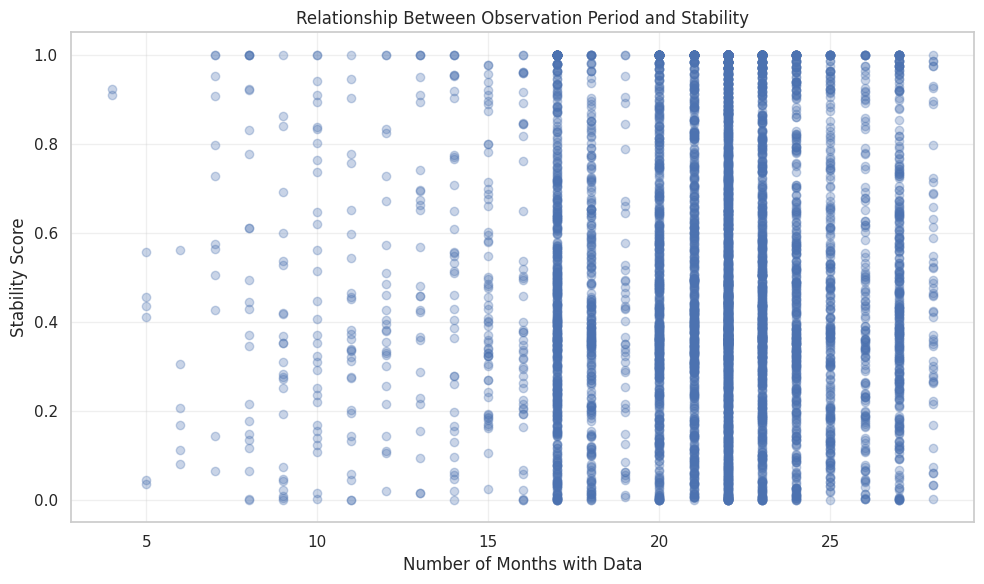

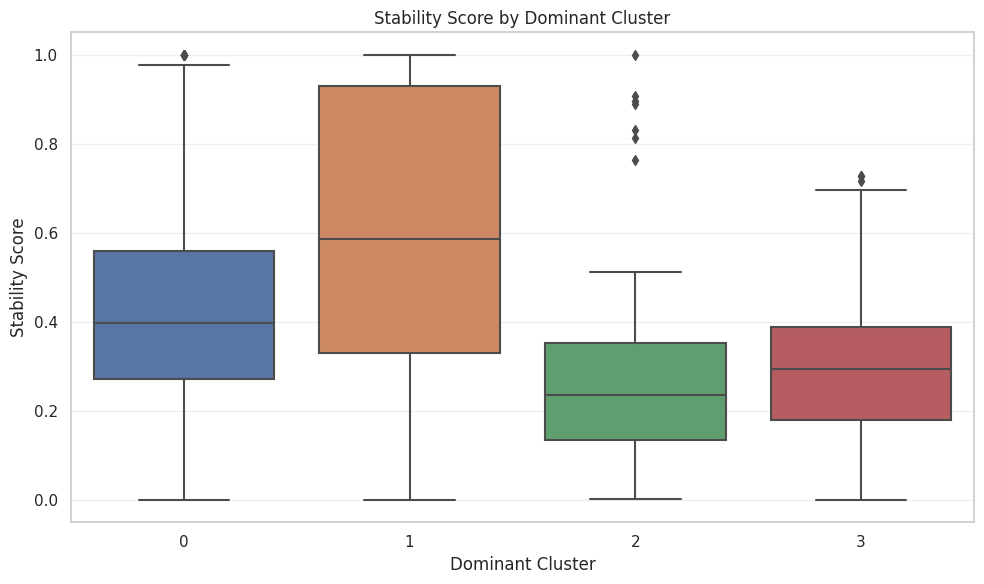

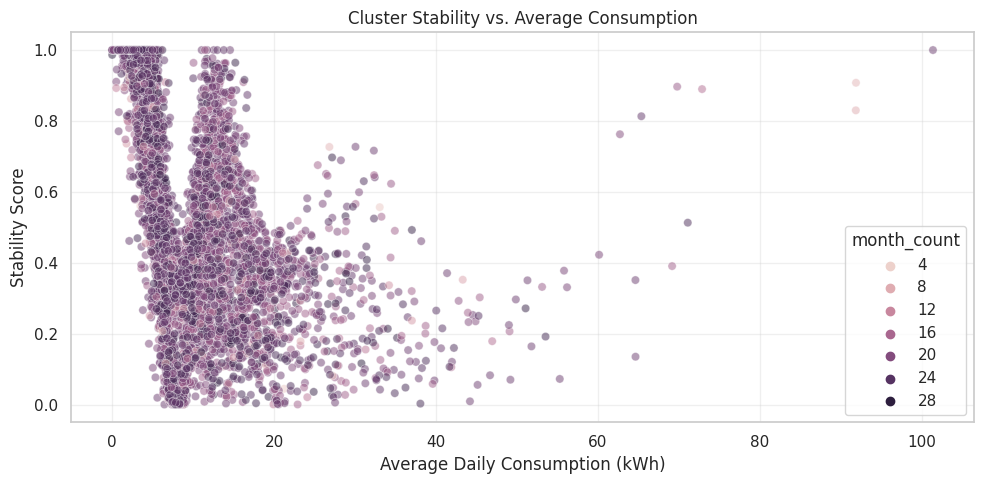


✅ Cluster Stability Analysis Complete!


LCLid  dominant_cluster  dominant_proportion   entropy  \
0     MAC000002                 0             0.831325  0.817708   
1     MAC000003                 0             0.708844  1.081736   
2     MAC000004                 1             1.000000 -0.000000   
3     MAC000005                 1             0.974643  0.170542   
4     MAC000006                 1             1.000000 -0.000000   
...         ...               ...                  ...       ...   
5551  MAC005561                 1             0.628975  0.951456   
5552  MAC005562                 0             0.804580  0.735364   
5553  MAC005564                 1             0.987741  0.095423   
5554  MAC005566                 1             0.475538  1.507111   
5555  MAC005567                 1             0.918981  0.405758   

      stability_score  month_count  
0            0.484084           17  
1            0.459132           25  
2            1.000000           22  
3            0.829458           21  
4            1.000000           26  
...               ...          ...  
5551         0.048544           19  
5552         0.536037           22  
5553         0.904577           19  
5554         0.246444           17  
5555         0.594242           15  

[5556 rows x 6 columns]

In [32]:
plot_cluster_stability_analysis(df_features, cluster_col="autoencoder_cluster")